In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="//fonts.googleapis.com/css?family=Quicksand:300"/>

<h1 align="center"><ins><font color='darkblue'>Problem Statement</font></ins></h1>
<h4>LTFS Top-Up Loan Up-Sell Prediction</h4>

* Loans are usually provided to Industries, Corporates and Individuals. The interest from those loans are the main source of income for the provider.
* A **top-up loan** is a facility of availing further funds on an existing loan.
* LTFS provides is interested in selling more of its Top-up loan services to its existing customers so they have decided to identify when to pitch a Top-up during the original loan tenure.
* If they correctly identify the most suitable time to offer a top-up, this will ultimately lead to more disbursals and can also help them beat competing offerings from other institutions.

<h4>Data Description</h4>

To understand customer behaviour, LTFS has assembled data for its customers containing the information whether that particular customer took the Top-up service and when he took such Top-up service.
There are 2 types of Data:-
1. <ins>**Customer’s Demographics**</ins>: This table contains demographic information variables related to Frequency of the loan, Tenure of the loan, Disbursal Amount for a loan & LTV. This also contains the target variable **Top-up Month**.
2. <ins>**Bureau data**</ins>: Bureau data contains the behavioural and transactional attributes of the customers like current balance, Loan Amount, Overdue etc. for various tradelines of a given customer.

<h4>Expected Output</h4>
As a data-scientist, We need to <b>build a model using the given train data to predict the right bucket/period for the customers in the test data<b>.

<h1 align="center"><ins><font color='darkblue'>Problem Category</font></ins></h1>

Let's start with some standard imports to take us through this exercise.

In [2]:
#For Reproducable results
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

#Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

#General
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import numpy as np
from tqdm.autonotebook import tqdm
import time
import os
import math
from datetime import datetime

#Visialisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from collections import Counter
from PIL import Image

#Machine Learning
#Pre-Processing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
#Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.decomposition import PCA
#Models
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_validate, StratifiedKFold, cross_val_score
#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow_addons.metrics import F1Score, FBetaScore
from tensorflow_addons.callbacks import TQDMProgressBar

#Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
#Hyper-Param Tuning
from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK

Since we are provided with the underlying data as well as the target variable it is clearly a [***SUPERVISED LEARNING***](https://developers.google.com/machine-learning/glossary#supervised-machine-learning) problem.  
Further in supervised learning category there are 2 major types of models: [*Classificarion*](https://developers.google.com/machine-learning/glossary#classification-model) and [*Regression*](https://developers.google.com/machine-learning/glossary#regression-model) model.  
We need to decide which category this problem falls into by looking at the [cardinality](https://en.wikipedia.org/wiki/Cardinality) of the target variable. Forthat we need to read-in the dataset and count the number of unique variables. The below block of code does exactly that.

In [3]:
train_data = pd.read_csv('./Data/Train/train_Data.csv', parse_dates=['DisbursalDate', 'MaturityDAte', 'AuthDate'])
test_data = pd.read_csv('./Data/Test/test_Data.csv', parse_dates=['DisbursalDate', 'MaturityDAte', 'AuthDate'])
train_bureau = pd.read_csv('./Data/Train/train_bureau.csv', parse_dates=['DATE-REPORTED', 'DISBURSED-DT', 'CLOSE-DT',
                                                                         'LAST-PAYMENT-DATE'])
test_bureau = pd.read_csv('./Data/Test/test_bureau.csv', parse_dates=['DATE-REPORTED', 'DISBURSED-DT', 'CLOSE-DT',
                                                                      'LAST-PAYMENT-DATE'])

train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()
train_bureau = train_bureau.drop_duplicates()
test_bureau = test_bureau.drop_duplicates()

train_data.head(15)

ID    Frequency InstlmentMode LoanStatus   PaymentMode  BranchID  \
0    1      Monthly        Arrear     Closed         PDC_E         1   
1    2      Monthly       Advance     Closed           PDC       333   
2    3      Quatrly        Arrear     Active  Direct Debit         1   
3    7      Monthly       Advance     Closed        Billed       125   
4    8      Monthly        Arrear     Closed        Billed       152   
5    9      Monthly        Arrear     Closed        Billed         5   
6   10      Monthly        Arrear     Closed         PDC_E         5   
7   11      Monthly        Arrear     Closed         PDC_E         5   
8   12      Monthly        Arrear     Closed           PDC         5   
9   13      Monthly        Arrear     Closed           PDC         5   
10  14      Monthly        Arrear     Closed           PDC         5   
11  15  Half Yearly        Arrear     Closed         PDC_E         5   
12  16      Monthly        Arrear     Closed         PDC_E       154   
13  17      Monthly        Arrear     Closed        Billed       152   
14  18      Monthly        Arrear     Closed           PDC         5   

        Area  Tenure  AssetCost  AmountFinance  DisbursalAmount       EMI  \
0        NaN      48     450000       275000.0         275000.0   24000.0   
1     BHOPAL      47     485000       350000.0         350000.0   10500.0   
2        NaN      68     690000       519728.0         519728.0   38300.0   
3       GUNA      48     480000       400000.0         400000.0   11600.0   
4   BILASPUR      44     619265       440000.0         440000.0   15000.0   
5     RAIPUR      48     400000       280000.0         280000.0   53000.0   
6     RAIPUR      48     716000       450000.0         450000.0    2000.0   
7     RAIPUR      48     600000       360000.0         360000.0   11000.0   
8     RAIPUR      46     539275       400000.0         400000.0   50000.0   
9     RAIPUR      48     689275       490000.0         490000.0   10000.0   
10    RAIPUR      33     800000       550000.0         550000.0  117000.0   
11    RAIPUR     240     675000       425000.0         425000.0   40000.0   
12       NaN      35     355000       280000.0         280000.0   60000.0   
13  BILASPUR      33     713295       490000.0         490000.0   80000.0   
14    RAIPUR      48     695000       450000.0         450000.0  155000.0   

   DisbursalDate MaturityDAte   AuthDate   AssetID  ManufacturerID  \
0     2012-02-10   2016-01-15 2012-02-10   4022465            1568   
1     2012-03-31   2016-02-15 2012-03-31   4681175            1062   
2     2017-06-17   2023-02-10 2017-06-17  25328146            1060   
3     2013-11-29   2017-11-10 2013-11-29  13021591            1060   
4     2011-12-08   2015-07-05 2011-12-08   3291320            1046   
5     2011-12-19   2015-12-15 2011-12-19   3413012            1019   
6     2011-12-31   2015-12-05 2011-12-31   3553579            1019   
7     2012-02-09   2016-02-15 2012-02-09   4008234            1187   
8     2012-03-29   2016-01-15 2012-03-29   4603217            1046   
9     2012-03-30   2016-02-15 2012-03-30   4619836            1046   
10    2012-04-20   2015-01-15 2012-04-20   4880715            1187   
11    2012-04-26   2016-01-15 2012-04-26   4956840            1187   
12    2012-04-30   2015-03-15 2012-04-30   5006614            1568   
13    2012-04-30   2015-01-15 2012-04-30   5011788            1046   
14    2012-06-30   2016-06-15 2012-06-30   5824429            1187   

    SupplierID    LTV SEX   AGE  MonthlyIncome         City           State  \
0        21946  61.11   M  49.0       35833.33       RAISEN  MADHYA PRADESH   
1        34802  70.00   M  23.0         666.67       SEHORE  MADHYA PRADESH   
2       127335  69.77   M  39.0       45257.00       BHOPAL  MADHYA PRADESH   
3        25094  80.92   M  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH   
4        21853  71.05   M  56.0       27313.67     BILASPUR     CHATTISGARH   
5        54689  70.00  

In [4]:
train_data.describe().T

count          mean           std        min         25%  \
ID               128655.0  7.096533e+04  4.176278e+04       1.00    34408.50   
BranchID         128655.0  1.662897e+02  1.158440e+02       1.00       50.00   
Tenure           128655.0  4.246478e+01  2.353397e+01       5.00       36.00   
AssetCost        128655.0  5.550247e+05  1.083036e+05  200000.00   500000.00   
AmountFinance    128655.0  3.483096e+05  1.055453e+05   50000.00   290000.00   
DisbursalAmount  128655.0  3.479306e+05  1.053198e+05    2894.00   290000.00   
EMI              128655.0  5.507276e+04  2.891011e+04       0.00    32500.00   
AssetID          128655.0  1.639773e+07  9.539540e+06  422271.00  9438948.50   
ManufacturerID   128655.0  1.171327e+03  2.577902e+02    1019.00     1046.00   
SupplierID       128655.0  5.655123e+04  3.639936e+04    5879.00    24093.00   
LTV              128655.0  5.912623e+01  1.553904e+01      -1.38       49.14   
AGE              128596.0  4.066480e+01  1.171285e+01      18.00       31.00   
MonthlyIncome    128421.0  5.032360e+04  1.724607e+06       0.00    25000.00   
ZiPCODE          128283.0  4.279311e+05  1.757044e+05  110000.00   304804.00   

                         50%          75%          max  
ID                  70988.00    106549.50     143395.0  
BranchID              152.00       274.00        424.0  
Tenure                 36.00        48.00        501.0  
AssetCost          550735.00    611000.00    2250000.0  
AmountFinance      350000.00    410000.00    1308351.0  
DisbursalAmount    350000.00    410000.00    1308351.0  
EMI                 59700.00     73800.00     460000.0  
AssetID          15133927.00  25333957.50   37066666.0  
ManufacturerID       1062.00      1186.00       3473.0  
SupplierID          39146.00     87034.00     145518.0  
LTV                    60.78        70.59        100.0  
AGE                    40.00        49.00         90.0  
MonthlyIncome       35833.33     50000.00  617477500.0  
ZiPCODE            458553.00    521131.00     855456.0

In [5]:
train_bureau.head(10)

ID  SELF-INDICATOR MATCH-TYPE             ACCT-TYPE CONTRIBUTOR-TYPE  \
0   1           False    PRIMARY             Overdraft              NAB   
1   1           False    PRIMARY  Auto Loan (Personal)              NAB   
2   1            True    PRIMARY          Tractor Loan              NBF   
3   1            True    PRIMARY  Auto Loan (Personal)              NBF   
4   1            True    PRIMARY          Tractor Loan              NBF   
5   1           False    PRIMARY           Credit Card              NAB   
6   1           False    PRIMARY  Auto Loan (Personal)              NAB   
7   1            True    PRIMARY  Auto Loan (Personal)              NBF   
8   1            True    PRIMARY  Auto Loan (Personal)              NBF   
9   2           False    PRIMARY             Overdraft              PRB   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT  \
0    2018-04-30    Individual     Delinquent   2015-10-05   
1    2019-12-31    Individual         Active   2018-03-19   
2    2020-01-31    Individual         Active   2019-08-30   
3    2017-09-30    Individual         Closed   2013-09-27   
4    2016-02-29    Individual         Closed   2012-02-10   
5    2018-04-30    Individual         Closed   2018-01-11   
6    2019-12-31    Individual         Active   2018-11-15   
7    2017-09-30    Individual         Closed   2013-01-30   
8    2017-07-31    Individual         Closed   2013-06-11   
9    2017-03-31    Individual         Closed   2016-01-15   

              CLOSE-DT LAST-PAYMENT-DATE CREDIT-LIMIT/SANC AMT  \
0                  NaN        2018-02-27                   NaN   
1                  NaN        2019-12-19                   NaN   
2                  NaN               NaT                   NaN   
3  2017-09-21 00:00:00               NaT                   NaN   
4  2016-02-01 00:00:00               NaT                   NaN   
5  2018-03-13 00:00:00               NaT                50,000   
6                  NaN        2019-12-15                   NaN   
7  2017-09-21 00:00:00               NaT                   NaN   
8  2017-07-01 00:00:00               NaT                   NaN   
9  2017-03-27 00:00:00        2017-03-27                   NaN   

  DISBURSED-AMT/HIGH CREDIT INSTALLMENT-AMT CURRENT-BAL INSTALLMENT-FREQUENCY  \
0                    37,352             NaN      37,873                   NaN   
1                    44,000   1,405/Monthly      20,797                   F03   
2                  1,45,000             NaN    1,16,087                   NaN   
3                  3,00,000             NaN           0                   NaN   
4                  2,75,000             NaN           0                   NaN   
5                         0             NaN           0                   NaN   
6                  5,00,000   7,934/Monthly    4,43,769                   F03   
7                  5,00,000             NaN           0                   NaN   
8                  4,00,000             NaN           0                   NaN   
9                 17,00,000             NaN           0                   NaN   

  OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0      37,873            0.0    Standard   
1         NaN            0.0    Standard   
2           0            0.0         NaN   
3           0            0.0         NaN   
4           0            0.0         NaN   
5         NaN            0.0    Standard   
6         NaN            0.0    Standard   
7           0            0.0         NaN   
8           0            0.0         NaN   
9           0            0.0         NaN   

                                REPORTED DATE - HIST  \
0                                 20180430,20180331,   
1  20191231,20191130,20191031,20190930,20190831,2...   
2  20200131,20191231,20191130,20191031,20190930,2...   
3  20170930,20170801,20170731,20170630,20170531,2...   
4  20160229,20160131,20151231,20151130,20151031,2...   
5                        20180331,20180228,20180131,   
6  201912

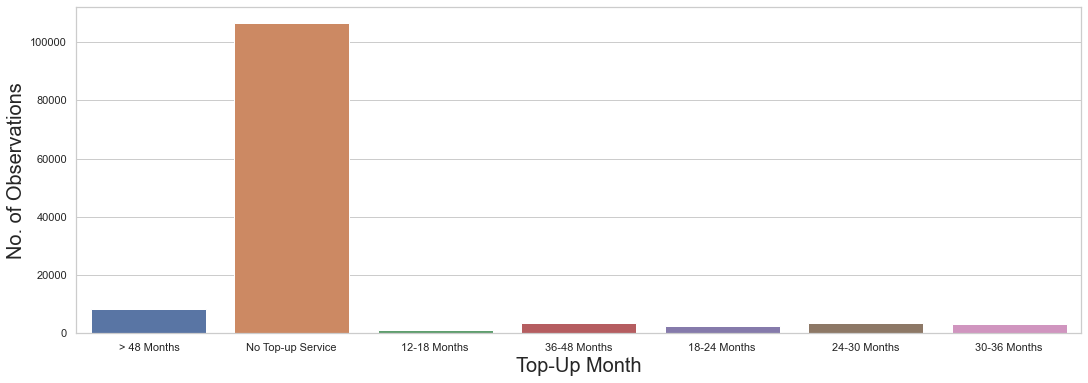

In [6]:
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
sns.countplot(x='Top-up Month', data=train_data);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Top-Up Month", size=20);

Since there are only 7 distinct classes in the trainig data, hence the cardinality of the target set is very low. Thus this is clearly an example of [***CLASSIFICATION PROBLEM***](https://developers.google.com/machine-learning/glossary#classification-model).<br>
Hence, the task at hand can be achieved by creating a <ins>***Supervised-Classification Model***</ins>.<br>
Also, since there is a huge difference in number of obcervations in each class, it falls under the categoty of ***Imbalanced Classification***.<br>
The unique classes which we have here are:-

In [7]:
top = Counter(train_data['Top-up Month'])
temp = pd.DataFrame.from_dict(top, orient='index').reset_index()
temp.columns = ['Top-up Month', 'Count']
temp.style.background_gradient(cmap='Reds')

<h1 align="center"><ins><font color='darkblue'>Joining Both Tables</font></ins></h1>

To join both tables, without creating duplicate ID's ideally we need to aggregate the bureau data to 1 entry per ID and then use that as out join key. So let's get the bureau table ready first. As we are going to perform similar operation on both the bureau tables, let's join them first, do operations and split-up them afterwards. It will make the task easier and cleaner.

In [8]:
train_bureau['Table'] = 'Train'
test_bureau['Table'] = 'Test'
bureau = pd.concat([train_bureau, test_bureau])

In [9]:
bureau.dtypes

ID                                    int64
SELF-INDICATOR                         bool
MATCH-TYPE                           object
ACCT-TYPE                            object
CONTRIBUTOR-TYPE                     object
DATE-REPORTED                datetime64[ns]
OWNERSHIP-IND                        object
ACCOUNT-STATUS                       object
DISBURSED-DT                 datetime64[ns]
CLOSE-DT                             object
LAST-PAYMENT-DATE            datetime64[ns]
CREDIT-LIMIT/SANC AMT                object
DISBURSED-AMT/HIGH CREDIT            object
INSTALLMENT-AMT                      object
CURRENT-BAL                          object
INSTALLMENT-FREQUENCY                object
OVERDUE-AMT                          object
WRITE-OFF-AMT                       float64
ASSET_CLASS                          object
REPORTED DATE - HIST                 object
DPD - HIST                           object
CUR BAL - HIST                       object
AMT OVERDUE - HIST              

There are clearly some features which should have been numeric datatype but are insted assigned as objects. Let's change that...

In [10]:
to_be_corrected = ['CREDIT-LIMIT/SANC AMT', 'DISBURSED-AMT/HIGH CREDIT', 'CURRENT-BAL', 'OVERDUE-AMT', 'INSTALLMENT-AMT']
def format_numbers_string(text):
    text = str(text)
    number = text.split('/')[0]
    number = float(number.replace(',', ''))
    return number

for col in to_be_corrected:
    bureau[col] = bureau[col].apply(lambda x : format_numbers_string(x))
    bureau[col] = bureau[col].astype('float64')
bureau.head(10)

ID  SELF-INDICATOR MATCH-TYPE             ACCT-TYPE CONTRIBUTOR-TYPE  \
0   1           False    PRIMARY             Overdraft              NAB   
1   1           False    PRIMARY  Auto Loan (Personal)              NAB   
2   1            True    PRIMARY          Tractor Loan              NBF   
3   1            True    PRIMARY  Auto Loan (Personal)              NBF   
4   1            True    PRIMARY          Tractor Loan              NBF   
5   1           False    PRIMARY           Credit Card              NAB   
6   1           False    PRIMARY  Auto Loan (Personal)              NAB   
7   1            True    PRIMARY  Auto Loan (Personal)              NBF   
8   1            True    PRIMARY  Auto Loan (Personal)              NBF   
9   2           False    PRIMARY             Overdraft              PRB   

  DATE-REPORTED OWNERSHIP-IND ACCOUNT-STATUS DISBURSED-DT  \
0    2018-04-30    Individual     Delinquent   2015-10-05   
1    2019-12-31    Individual         Active   2018-03-19   
2    2020-01-31    Individual         Active   2019-08-30   
3    2017-09-30    Individual         Closed   2013-09-27   
4    2016-02-29    Individual         Closed   2012-02-10   
5    2018-04-30    Individual         Closed   2018-01-11   
6    2019-12-31    Individual         Active   2018-11-15   
7    2017-09-30    Individual         Closed   2013-01-30   
8    2017-07-31    Individual         Closed   2013-06-11   
9    2017-03-31    Individual         Closed   2016-01-15   

              CLOSE-DT LAST-PAYMENT-DATE  CREDIT-LIMIT/SANC AMT  \
0                  NaN        2018-02-27                    NaN   
1                  NaN        2019-12-19                    NaN   
2                  NaN               NaT                    NaN   
3  2017-09-21 00:00:00               NaT                    NaN   
4  2016-02-01 00:00:00               NaT                    NaN   
5  2018-03-13 00:00:00               NaT                50000.0   
6                  NaN        2019-12-15                    NaN   
7  2017-09-21 00:00:00               NaT                    NaN   
8  2017-07-01 00:00:00               NaT                    NaN   
9  2017-03-27 00:00:00        2017-03-27                    NaN   

   DISBURSED-AMT/HIGH CREDIT  INSTALLMENT-AMT  CURRENT-BAL  \
0                    37352.0              NaN      37873.0   
1                    44000.0           1405.0      20797.0   
2                   145000.0              NaN     116087.0   
3                   300000.0              NaN          0.0   
4                   275000.0              NaN          0.0   
5                        0.0              NaN          0.0   
6                   500000.0           7934.0     443769.0   
7                   500000.0              NaN          0.0   
8                   400000.0              NaN          0.0   
9                  1700000.0              NaN          0.0   

  INSTALLMENT-FREQUENCY  OVERDUE-AMT  WRITE-OFF-AMT ASSET_CLASS  \
0                   NaN      37873.0            0.0    Standard   
1                   F03          NaN            0.0    Standard   
2                   NaN          0.0            0.0         NaN   
3                   NaN          0.0            0.0         NaN   
4                   NaN          0.0            0.0         NaN   
5                   NaN          NaN            0.0    Standard   
6                   F03          NaN            0.0    Standard   
7                   NaN          0.0            0.0         NaN   
8                   NaN          0.0            0.0         NaN   
9                   NaN          0.0            0.0         NaN   

                                REPORTED DATE - HIST  \
0                                 20180430,20180331,   
1  20191231,20191130,20191031,20190930,20190831,2...   
2  20200131,20191231,20191130,20191031,20190930,2...   
3  20170930,20170801,20170731,20170630,20170531,2...   
4  20160229,20160131,20151231,20151130,20151031,2...   
5         

In [11]:
bureau.describe().T

count           mean           std         min  \
ID                         620311.0   68076.958574  4.077319e+04         1.0   
CREDIT-LIMIT/SANC AMT       16688.0   41124.375539  9.241281e+04   -700000.0   
DISBURSED-AMT/HIGH CREDIT  620273.0  316089.300595  5.195395e+06    -83878.0   
INSTALLMENT-AMT            153976.0   60594.940802  1.823219e+05   -205235.0   
CURRENT-BAL                620047.0  103253.724219  8.529769e+05 -20868956.0   
OVERDUE-AMT                489247.0    5178.304071  8.551329e+04   -545273.0   
WRITE-OFF-AMT              598688.0     293.427071  1.963489e+04       -30.0   
TENURE                     211023.0      29.333523  3.244340e+01         0.0   

                               25%       50%       75%          max  
ID                         33213.0   63148.0  101778.5     143400.0  
CREDIT-LIMIT/SANC AMT          0.0   20000.0   44000.0    3750000.0  
DISBURSED-AMT/HIGH CREDIT  49000.0  195000.0  354734.0  999999999.0  
INSTALLMENT-AMT              692.0   15345.0   71260.0   39961890.0  
CURRENT-BAL                    0.0       0.0   76520.0  375991329.0  
OVERDUE-AMT                    0.0       0.0       0.0   25755236.0  
WRITE-OFF-AMT                  0.0       0.0       0.0    8797356.0  
TENURE                        12.0      24.0      36.0        856.0

In [12]:
bureau_columns = list(bureau.columns)

In [13]:
def sum_all_csv(text):
    if text == text:
        nums = text.split(',')
        list_num = [ float(x) for x in nums if x != '']
        total = sum(list_num)
    else:
        total = 0
    return total

In [14]:
numeric_hist_features = ['CUR BAL - HIST', 'AMT OVERDUE - HIST', 'AMT PAID - HIST']
for col in numeric_hist_features:
    bureau[col.split(' - ')[0] + '_Hist_Sum'] = bureau[col].apply(sum_all_csv)

In [15]:
datetime_columns = []
numeric_columns = []
object_columns = []

numerical_data_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for col in bureau_columns:
    if bureau[col].dtype in numerical_data_types:
        numeric_columns.append(col)
    elif bureau[col].dtype == 'datetime64[ns]':
        datetime_columns.append(col)
    else:
        object_columns.append(col)
        
print(f'There are {len(numeric_columns)} Numerical features.')
print(f'Numerical Features: {numeric_columns}')
print(f'There are {len(object_columns)} Non-Numeric features.')
print(f'Non-Numeric Features: {object_columns}')
print(f'There are {len(datetime_columns)} Date-Time features.')
print(f'Date-Time Features: {datetime_columns}')

There are 8 Numerical features.
Numerical Features: ['ID', 'CREDIT-LIMIT/SANC AMT', 'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT', 'CURRENT-BAL', 'OVERDUE-AMT', 'WRITE-OFF-AMT', 'TENURE']
There are 15 Non-Numeric features.
Non-Numeric Features: ['SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'CLOSE-DT', 'INSTALLMENT-FREQUENCY', 'ASSET_CLASS', 'REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST', 'AMT OVERDUE - HIST', 'AMT PAID - HIST', 'Table']
There are 3 Date-Time features.
Date-Time Features: ['DATE-REPORTED', 'DISBURSED-DT', 'LAST-PAYMENT-DATE']


In [16]:
for col in object_columns:
    print(bureau[col].value_counts())
    print('\n')

False    438401
True     181910
Name: SELF-INDICATOR, dtype: int64


PRIMARY      620086
SECONDARY       225
Name: MATCH-TYPE, dtype: int64


Tractor Loan                                                           207869
Gold Loan                                                               98370
Business Loan Priority Sector  Agriculture                              88083
Kisan Credit Card                                                       37588
Auto Loan (Personal)                                                    33432
Other                                                                   29602
Commercial Vehicle Loan                                                 20484
Two-Wheeler Loan                                                        17641
Credit Card                                                             14081
Consumer Loan                                                           13675
Overdraft                                                               10445


Name: REPORTED DATE - HIST, Length: 63027, dtype: int64


0                                                                                                               43639
XXX                                                                                                             42699
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000    26441
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX    12280
000                                                                                                              8406
                                                                                                                ...  
000000000000000000000000000000000000000000000000000000082051022000000000000000                                      1
000000000000000000000000000013003000                                                                                

The cardinality of some of the object columns is just too high. Let's manually and logically try to replace similar groups with identical classes.  
First let's club together the sparsely populated classes (<3 %) in *ACCT-TYPE* and *CONTRIBUTOR-TYPE*.

In [17]:
bureau['ACCT-TYPE'] = bureau['ACCT-TYPE'].replace(bureau['ACCT-TYPE'].value_counts()[bureau['ACCT-TYPE'].value_counts()/bureau.shape[0]*100<3].index, 'REST')
bureau['ACCT-TYPE'].value_counts()

Tractor Loan                                  207869
REST                                          104883
Gold Loan                                      98370
Business Loan Priority Sector  Agriculture     88083
Kisan Credit Card                              37588
Auto Loan (Personal)                           33432
Other                                          29602
Commercial Vehicle Loan                        20484
Name: ACCT-TYPE, dtype: int64

In [18]:
bureau['CONTRIBUTOR-TYPE'] = bureau['CONTRIBUTOR-TYPE'].replace(bureau['CONTRIBUTOR-TYPE'].value_counts()[bureau['CONTRIBUTOR-TYPE'].value_counts()/bureau.shape[0]*100<3].index, 'REST')
bureau['CONTRIBUTOR-TYPE'].value_counts()

NBF     285776
NAB     190914
PRB      83567
RRB      26315
COP      24203
REST      9536
Name: CONTRIBUTOR-TYPE, dtype: int64

Also let's club together the ACCOUNT-STATUS classes which basically mean that the account has been Inactive/Settled.

In [19]:
bureau['ACCOUNT-STATUS'] = bureau['ACCOUNT-STATUS'].replace(['SUIT FILED (WILFUL DEFAULT)', 'Written Off', 'Suit Filed',
                                                             'Restructured', 'Settled', 'WILFUL DEFAULT', 'Cancelled',
                                                             'Sold/Purchased'], 'Written Off')
bureau['ACCOUNT-STATUS'].value_counts()

Closed         351441
Active         225266
Delinquent      36883
Written Off      6721
Name: ACCOUNT-STATUS, dtype: int64

The - HIST columns look very messy and difficult to work with. Let's drop it now asnd we can revisit if we need it later.

In [20]:
bureau = bureau.drop(['REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST','AMT OVERDUE - HIST', 'AMT PAID - HIST'], axis=1)

Okay, now we have to know how useful is the data and what portion of the nulls we need to fill.

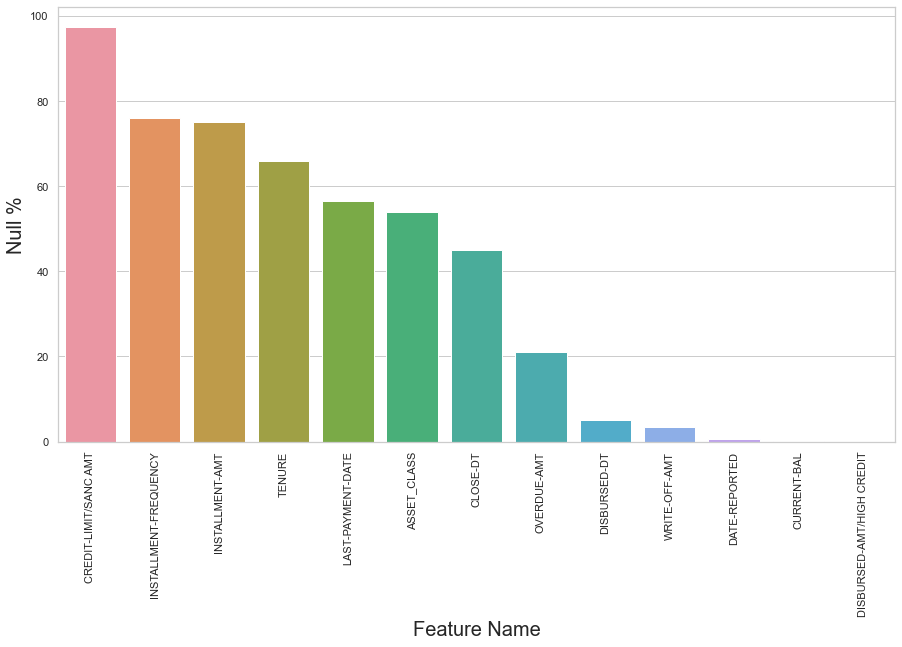

There are 13 features with missing values in the training data.
Columns containing nulls are: ['CREDIT-LIMIT/SANC AMT', 'INSTALLMENT-FREQUENCY', 'INSTALLMENT-AMT', 'TENURE', 'LAST-PAYMENT-DATE', 'ASSET_CLASS', 'CLOSE-DT', 'OVERDUE-AMT', 'DISBURSED-DT', 'WRITE-OFF-AMT', 'DATE-REPORTED', 'CURRENT-BAL', 'DISBURSED-AMT/HIGH CREDIT']


In [21]:
nulls_train = np.sum(bureau.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)
nullcols_train = nullcols_train.apply(lambda x: 100*x/bureau.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
plt.xticks(rotation=90)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()
print('There are', len(nullcols_train), 'features with missing values in the training data.')
print(f'Columns containing nulls are: {list(nullcols_train.index)}')

Okay, now let's look at them individually:-  
1. CREDIT-LIMIT/SANC AMT is an highly dependent feature and with such high values of NaN it's almost impossible to speculate it and fill it up with something resonable.  
   Solution:- Drop the Column
2. INSTALLMENT-FREQUENCY, INSTALLMENT-AMT and TENURE are interlinked features and we need atleast 2 of them to calculate the missing one approximately. But since all 3 of them have such high values of NaN it is highly unlikely that we can best approximate them logically.  
   Solution:- Drop the Column
3. LAST-PAYMENT-DATE, ASSET_CLASS and  CLOSE-DT are again a very basic and primitive feature which can not logically be derived from any dependent features in the table.  
   Solution:- Drop the Column
4. OVERDUE-AMT and WRITE-OFF-AMT can be **ASSUMED** to be 0 in case it's absent.  
   Solution:- Impute with zeros
5. DISBURSED-DT can not be derived without presence of any approval date or something similar.  
   Solution:- Drop the Column
6. DATE-REPORTED is just the extremity of the timeline in which the data is collected. Not much importance/Relationship with loan.  
   Solution:- Drop the Column
7. CURRENT-BAL can be imputed by grouping on ID and taking the mean value by **ASSUMING** a similar relationship.  
   Solution:- Groupby ID and take mean.
8. DISBURSED-AMT/HIGH CREDIT can be **ASSUMED** as grouping on ID and taking mean.  
   Solution:- Groupby ID and take mean.  
  
Now let's implement that in code

In [22]:
to_be_dropped = ['CREDIT-LIMIT/SANC AMT', 'INSTALLMENT-FREQUENCY', 'INSTALLMENT-AMT', 'TENURE', 'LAST-PAYMENT-DATE',
                 'ASSET_CLASS', 'CLOSE-DT', 'DISBURSED-DT', 'DATE-REPORTED']
bureau = bureau.drop(to_be_dropped, axis=1)

In [23]:
bureau['OVERDUE-AMT'] = bureau['OVERDUE-AMT'].fillna(0)
bureau['WRITE-OFF-AMT'] = bureau['WRITE-OFF-AMT'].fillna(0)

In [24]:
bureau['CURRENT-BAL'] = bureau.groupby('ID')['CURRENT-BAL'].transform(lambda x: x.fillna(x.mean()))
bureau['DISBURSED-AMT/HIGH CREDIT'] = bureau.groupby('ID')['DISBURSED-AMT/HIGH CREDIT'].transform(lambda x: x.fillna(x.mean()))

In [25]:
bureau.isnull().sum()

ID                           0
SELF-INDICATOR               0
MATCH-TYPE                   0
ACCT-TYPE                    0
CONTRIBUTOR-TYPE             0
OWNERSHIP-IND                0
ACCOUNT-STATUS               0
DISBURSED-AMT/HIGH CREDIT    0
CURRENT-BAL                  0
OVERDUE-AMT                  0
WRITE-OFF-AMT                0
Table                        0
CUR BAL_Hist_Sum             0
AMT OVERDUE_Hist_Sum         0
AMT PAID_Hist_Sum            0
dtype: int64

In [26]:
datetime_columns = []
numeric_columns = []
object_columns = []
bureau_columns = list(bureau.columns)

numerical_data_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']

for col in bureau_columns:
    if bureau[col].dtype in numerical_data_types:
        numeric_columns.append(col)
    elif bureau[col].dtype == 'datetime64[ns]':
        datetime_columns.append(col)
    else:
        object_columns.append(col)
        
print(f'There are {len(numeric_columns)} Numerical features.')
print(f'Numerical Features: {numeric_columns}')
print(f'There are {len(object_columns)} Non-Numeric features.')
print(f'Non-Numeric Features: {object_columns}')
print(f'There are {len(datetime_columns)} Date-Time features.')
print(f'Date-Time Features: {datetime_columns}')

There are 8 Numerical features.
Numerical Features: ['ID', 'DISBURSED-AMT/HIGH CREDIT', 'CURRENT-BAL', 'OVERDUE-AMT', 'WRITE-OFF-AMT', 'CUR BAL_Hist_Sum', 'AMT OVERDUE_Hist_Sum', 'AMT PAID_Hist_Sum']
There are 7 Non-Numeric features.
Non-Numeric Features: ['SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'Table']
There are 0 Date-Time features.
Date-Time Features: []


In [27]:
bureau.dtypes

ID                             int64
SELF-INDICATOR                  bool
MATCH-TYPE                    object
ACCT-TYPE                     object
CONTRIBUTOR-TYPE              object
OWNERSHIP-IND                 object
ACCOUNT-STATUS                object
DISBURSED-AMT/HIGH CREDIT    float64
CURRENT-BAL                  float64
OVERDUE-AMT                  float64
WRITE-OFF-AMT                float64
Table                         object
CUR BAL_Hist_Sum             float64
AMT OVERDUE_Hist_Sum         float64
AMT PAID_Hist_Sum            float64
dtype: object

In [28]:
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# OH_cols = pd.DataFrame(OH_encoder.fit_transform(bureau[object_columns]))
OH_cols = pd.get_dummies(data=bureau[['SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND',
                                      'ACCOUNT-STATUS', 'Table']],
                         columns=['SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE', 'OWNERSHIP-IND',
                                  'ACCOUNT-STATUS'])
bureau = bureau.drop(object_columns, axis=1)
bureau = pd.concat([bureau, OH_cols], axis=1)

In [29]:
bureau_data = bureau.groupby(['ID', 'Table']).sum().reset_index()
bureau_data= bureau_data.add_suffix('_bureau')

In [30]:
train_bureau = bureau_data[bureau_data['Table_bureau'] == 'Train']
test_bureau = bureau_data[bureau_data['Table_bureau'] == 'Test']

train_bureau = train_bureau.drop(['Table_bureau'], axis=1)
test_bureau = test_bureau.drop(['Table_bureau'], axis=1)

In [31]:
train_df = train_data.set_index('ID').join(train_bureau.set_index('ID_bureau')).reset_index()
train_df.head()

ID Frequency InstlmentMode LoanStatus   PaymentMode  BranchID      Area  \
0   1   Monthly        Arrear     Closed         PDC_E         1       NaN   
1   2   Monthly       Advance     Closed           PDC       333    BHOPAL   
2   3   Quatrly        Arrear     Active  Direct Debit         1       NaN   
3   7   Monthly       Advance     Closed        Billed       125      GUNA   
4   8   Monthly        Arrear     Closed        Billed       152  BILASPUR   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      48     450000       275000.0         275000.0  24000.0    2012-02-10   
1      47     485000       350000.0         350000.0  10500.0    2012-03-31   
2      68     690000       519728.0         519728.0  38300.0    2017-06-17   
3      48     480000       400000.0         400000.0  11600.0    2013-11-29   
4      44     619265       440000.0         440000.0  15000.0    2011-12-08   

  MaturityDAte   AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2016-01-15 2012-02-10   4022465            1568       21946  61.11   M   
1   2016-02-15 2012-03-31   4681175            1062       34802  70.00   M   
2   2023-02-10 2017-06-17  25328146            1060      127335  69.77   M   
3   2017-11-10 2013-11-29  13021591            1060       25094  80.92   M   
4   2015-07-05 2011-12-08   3291320            1046       21853  71.05   M   

    AGE  MonthlyIncome         City           State   ZiPCODE  \
0  49.0       35833.33       RAISEN  MADHYA PRADESH  464993.0   
1  23.0         666.67       SEHORE  MADHYA PRADESH  466001.0   
2  39.0       45257.00       BHOPAL  MADHYA PRADESH  462030.0   
3  24.0       20833.33  ASHOK NAGAR  MADHYA PRADESH  473335.0   
4  56.0       27313.67     BILASPUR     CHATTISGARH  495442.0   

        Top-up Month  DISBURSED-AMT/HIGH CREDIT_bureau  CURRENT-BAL_bureau  \
0        > 48 Months                         2201352.0            618526.0   
1  No Top-up Service                        18117081.0          10349457.0   
2       12-18 Months                         3708369.0           2065165.0   
3        > 48 Months                         1272553.0            624000.0   
4       36-48 Months                         2025216.0            974119.0   

   OVERDUE-AMT_bureau  WRITE-OFF-AMT_bureau  CUR BAL_Hist_Sum_bureau  \
0             37873.0                   0.0               26538866.0   
1                 0.0                   0.0              148166021.0   
2            103490.0                   0.0               84027186.0   
3                 0.0                   0.0               19057982.0   
4             35185.0                   0.0               33567641.0   

   AMT OVERDUE_Hist_Sum_bureau  AMT PAID_Hist_Sum_bureau  \
0                     133531.0                      0.00   
1                      62654.0               22432902.00   
2                    1367236.0                1328572.98   
3                          0.0                      0.00   
4                     304647.0                 202930.00   

   SELF-INDICATOR_False_bureau  SELF-INDICATOR_True_bureau  \
0                            4                           5   
1                           12                           1   
2                           29                           2   
3                            2                           2   
4                            6                           1   

   MATCH-TYPE_PRIMARY_bureau  MATCH-TYPE_SECONDARY_bureau  \
0                          9                            0   
1                         13                            0   
2                         31                            0   
3                          4                            0   
4                          7                            0   

   ACCT-TYPE_Auto Loan (Personal)_bureau  \
0                                      5   
1                                      1   
2                                      0   
3                   

In [32]:
test_df = test_data.set_index('ID').join(test_bureau.set_index('ID_bureau')).reset_index()
test_df.head()

ID    Frequency InstlmentMode LoanStatus PaymentMode  BranchID     Area  \
0    4      Monthly       Advance     Closed       PDC_E         2     GUNA   
1    5      Monthly       Advance     Closed         PDC         2     GUNA   
2    6      Quatrly        Arrear     Closed         PDC         2     GUNA   
3   25  Half Yearly        Arrear     Closed      Billed       154      NaN   
4  119      Quatrly        Arrear     Closed         PDC       194  CUTTACK   

   Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI DisbursalDate  \
0      46     480000       365000.0         365000.0   1000.0    2011-12-29   
1      45     480000       285000.0         285000.0   9300.0    2012-04-28   
2      48     580000       400000.0         400000.0  35800.0    2013-10-22   
3      36     725000       500000.0         500000.0  52000.0    2013-05-21   
4      48     617000       400000.0         400000.0  35400.0    2012-11-30   

  MaturityDAte   AuthDate   AssetID  ManufacturerID  SupplierID    LTV SEX  \
0   2015-10-05 2011-12-29   3524747          1046.0       22354  75.83   M   
1   2016-01-01 2012-04-28   4985862          1046.0       22354  57.44   M   
2   2017-09-10 2013-10-22  12881783          1060.0       65929  68.97   M   
3   2016-02-10 2013-05-21  10613776          1049.0       68597  61.79   M   
4   2016-12-05 2012-11-30   7911110          1049.0       38493  59.09   M   

    AGE  MonthlyIncome            City           State   ZiPCODE  \
0  50.0       32069.00            GUNA  MADHYA PRADESH  473001.0   
1  35.0       25000.00            GUNA  MADHYA PRADESH  473001.0   
2  37.0       23333.33            GUNA  MADHYA PRADESH  473001.0   
3  55.0       91666.67      MAHASAMUND     CHATTISGARH  493558.0   
4  48.0       12500.00  JAGATSINGHAPUR          ORISSA  754137.0   

   DISBURSED-AMT/HIGH CREDIT_bureau  CURRENT-BAL_bureau  OVERDUE-AMT_bureau  \
0                         2964588.0           2191274.0                 0.0   
1                         1939813.0            907231.0                 0.0   
2                         3237361.0            102800.0                 0.0   
3                          800000.0            127593.0                 0.0   
4                          930000.0            116200.0                 0.0   

   WRITE-OFF-AMT_bureau  CUR BAL_Hist_Sum_bureau  AMT OVERDUE_Hist_Sum_bureau  \
0                   0.0               75444793.0                      77502.0   
1                   0.0               41077711.0                     185821.0   
2                   0.0               25087010.0                     598111.0   
3                   0.0               10872525.0                          0.0   
4                   0.0               18070247.0                      11116.0   

   AMT PAID_Hist_Sum_bureau  SELF-INDICATOR_False_bureau  \
0                       0.0                            3   
1                       0.0                            7   
2                       0.0                           10   
3                       0.0                            1   
4                19080000.0                            1   

   SELF-INDICATOR_True_bureau  MATCH-TYPE_PRIMARY_bureau  \
0                           1                          4   
1                           1                          8   
2                           2                         12   
3                           1                          2   
4                           1                          2   

   MATCH-TYPE_SECONDARY_bureau  ACCT-TYPE_Auto Loan (Personal)_bureau  \
0                            0                                      0   
1                            0                                      0   
2                            0                                      7   
3                            0                                      0   
4                            0                                      1   

   ACCT-TYPE_Business Loan Priority Sector  Agricultu

<h1 align="center"><ins><font color='darkblue'>Basic EDA</font></ins></h1>

Let's explore each individual feature in the **Demographics data** and try to derive some insights and understand the data a bit better.  
First Let us see which of the columns are numerical features.

In [33]:
train_df.dtypes

ID                                                                      int64
Frequency                                                              object
InstlmentMode                                                          object
LoanStatus                                                             object
PaymentMode                                                            object
BranchID                                                                int64
Area                                                                   object
Tenure                                                                  int64
AssetCost                                                               int64
AmountFinance                                                         float64
DisbursalAmount                                                       float64
EMI                                                                   float64
DisbursalDate                                                  d

In [34]:
all_columns = train_df.columns
print(f'Total features provided in the Demographics dataset is: {len(all_columns)}')
numerical_data_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']

numerical_features = []
other_features = []
datetime_features = []

for col in all_columns:
    if train_df[col].dtype in numerical_data_types:
        numerical_features.append(col)
    elif train_df[col].dtype == 'datetime64[ns]':
        datetime_features.append(col)
    else:
        other_features.append(col)

print(f'There are {len(numerical_features)} Numerical features.')
print(f'Numerical Features: {numerical_features}')
print(f'There are {len(other_features)} Non-Numeric features.')
print(f'Non-Numeric Features: {other_features}')
print(f'There are {len(datetime_features)} Date-Time features.')
print(f'Date-Time Features: {datetime_features}')

Total features provided in the Demographics dataset is: 60
There are 48 Numerical features.
Numerical Features: ['ID', 'BranchID', 'Tenure', 'AssetCost', 'AmountFinance', 'DisbursalAmount', 'EMI', 'AssetID', 'ManufacturerID', 'SupplierID', 'LTV', 'AGE', 'MonthlyIncome', 'ZiPCODE', 'DISBURSED-AMT/HIGH CREDIT_bureau', 'CURRENT-BAL_bureau', 'OVERDUE-AMT_bureau', 'WRITE-OFF-AMT_bureau', 'CUR BAL_Hist_Sum_bureau', 'AMT OVERDUE_Hist_Sum_bureau', 'AMT PAID_Hist_Sum_bureau', 'SELF-INDICATOR_False_bureau', 'SELF-INDICATOR_True_bureau', 'MATCH-TYPE_PRIMARY_bureau', 'MATCH-TYPE_SECONDARY_bureau', 'ACCT-TYPE_Auto Loan (Personal)_bureau', 'ACCT-TYPE_Business Loan Priority Sector  Agriculture_bureau', 'ACCT-TYPE_Commercial Vehicle Loan_bureau', 'ACCT-TYPE_Gold Loan_bureau', 'ACCT-TYPE_Kisan Credit Card_bureau', 'ACCT-TYPE_Other_bureau', 'ACCT-TYPE_REST_bureau', 'ACCT-TYPE_Tractor Loan_bureau', 'CONTRIBUTOR-TYPE_COP_bureau', 'CONTRIBUTOR-TYPE_NAB_bureau', 'CONTRIBUTOR-TYPE_NBF_bureau', 'CONTRIBUTOR-T

## 1. Numerical Features:-  
Now we need to find what is the cardinality of each of the numerical column so that we can determine which of them are continuous(high cardinality) and which are categorical(low cardinality).

In [35]:
train_df[numerical_features].nunique()

ID                                                             128655
BranchID                                                          189
Tenure                                                            141
AssetCost                                                        7835
AmountFinance                                                   20439
DisbursalAmount                                                 19412
EMI                                                             24323
AssetID                                                        128655
ManufacturerID                                                     10
SupplierID                                                       4539
LTV                                                              7988
AGE                                                                73
MonthlyIncome                                                   11568
ZiPCODE                                                          9123
DISBURSED-AMT/HIGH C

From this we can conclude ManufacturerID can be a categorical variable because it has a very low cardinality. Also from definition we can also conclude that BranchID, AssetID, SupplierID and ZiPCODE are categorical value. Because those are some sort of IDs, which have no numerical significance when compared to one another. Also the feature ID is sort of line a unique identifier for the loan agreement, and thus not really a feature. So we can ignore it while doing EDA.

In [36]:
numerical_categorical_features = ['ManufacturerID', 'BranchID', 'AssetID', 'SupplierID', 'ZiPCODE']
numerical_continuous_features = []
for feat in numerical_features:
    if (feat not in numerical_categorical_features) and feat != 'ID':
        numerical_continuous_features.append(feat)

Now let us examine the distribution and correlation between various numerical continuous features.

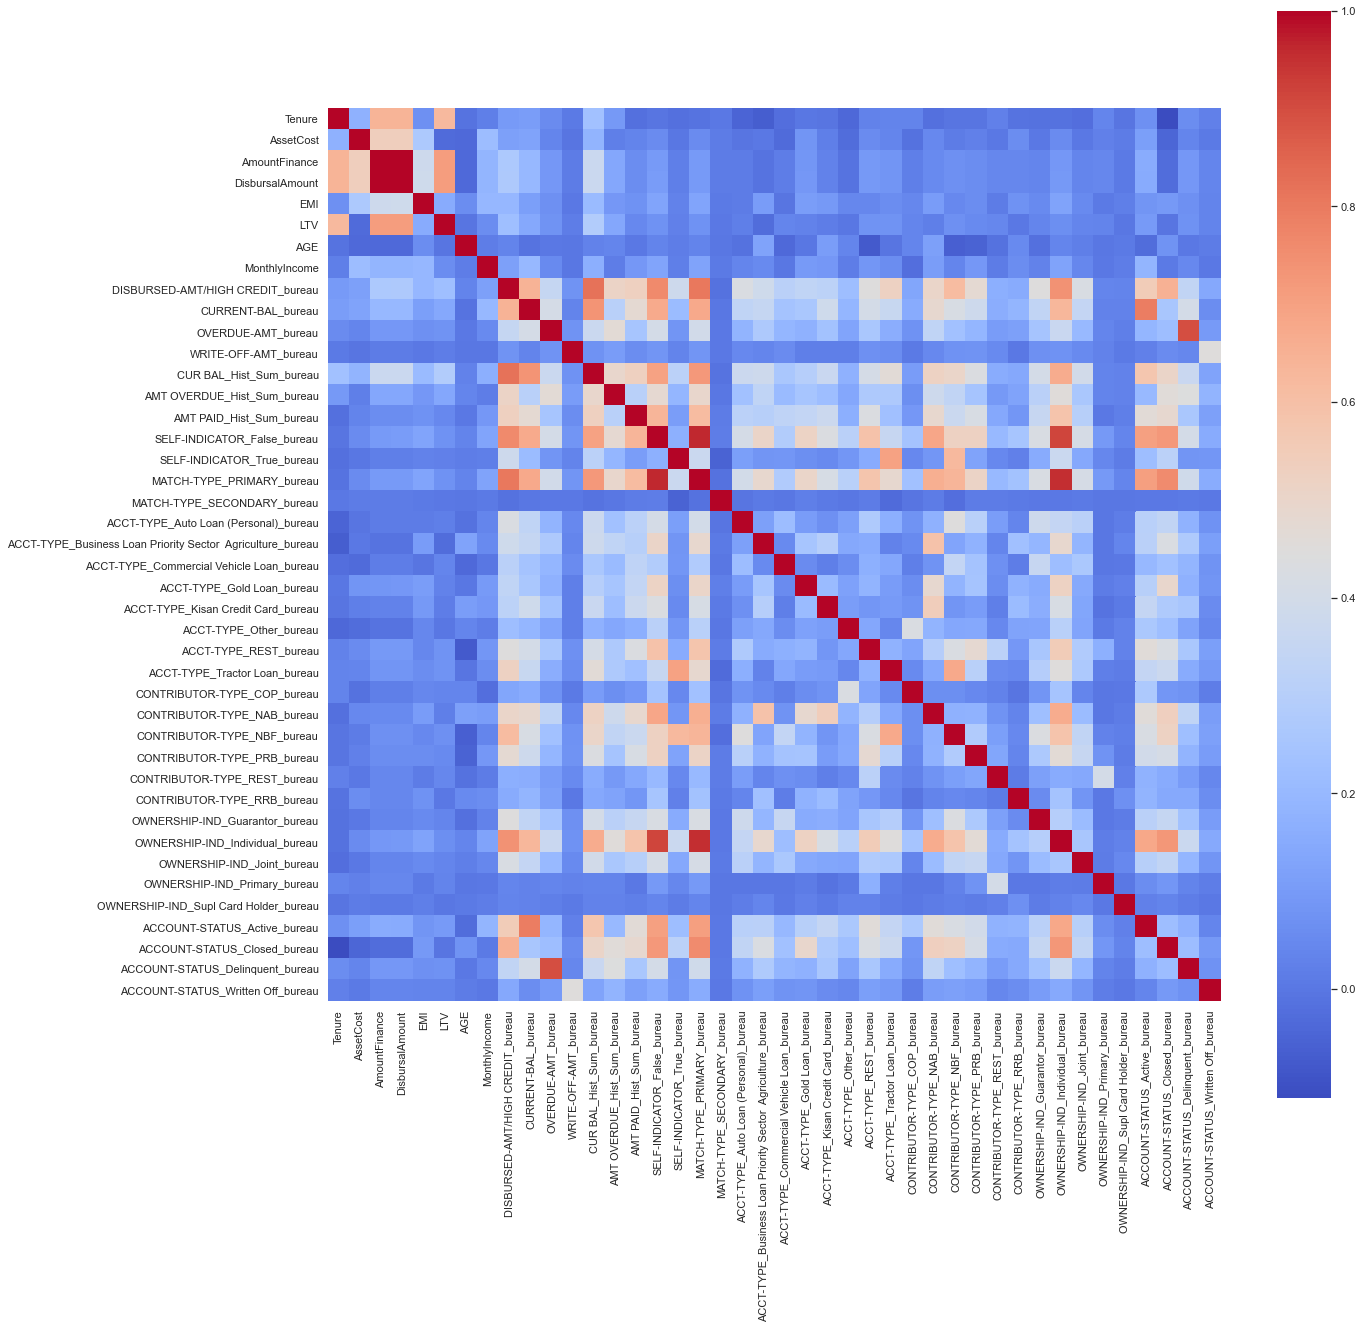

In [37]:
train_df_cor_spear = train_df[numerical_continuous_features].corr(method='spearman')
plt.figure(figsize=(20,20))
sns.heatmap(train_df_cor_spear,square=True,cmap='coolwarm');

From this we can see and verify the fact mentioned in data_dict that AmountFinance is most of the times equal to DisbursalAmount. So there is no need of keeping both the features, so wee can drop the AmountFinance feature and in its place we can **introduce a syntetic feature which signifies the deficit in the amount**.

In [38]:
# fig, axes = plt.subplots((len(numerical_continuous_features)//3)+1, 3, figsize=(24, 12))

# i = 0
# for triaxis in axes:
#     for axis in triaxis:
#         sns.distplot(train_df[numerical_continuous_features[i]], ax=axis)
#         i = i+1
#         if i == len(numerical_continuous_features):
#             break

## 2. Non-Numeric Features:-  
Now looking at the Non-Numeric features, let's see what we can uncover.

In [39]:
other_features = other_features + numerical_categorical_features
train_df[other_features].nunique()

Frequency              4
InstlmentMode          2
LoanStatus             2
PaymentMode           11
Area                  92
SEX                    2
City                 488
State                 22
Top-up Month           7
ManufacturerID        10
BranchID             189
AssetID           128655
SupplierID          4539
ZiPCODE             9123
dtype: int64

We can further divide the features into low cardinality and high cardinality columns based on their unique values.

In [40]:
low_cardinality_features = []
high_cardinality_features = []
for feat in other_features:
    if train_df[feat].nunique() < 11:
        low_cardinality_features.append(feat)
    else:
        high_cardinality_features.append(feat)
        
print(f'Low Cardinality Features: {low_cardinality_features}')
print(f'High Cardinality Features: {high_cardinality_features}')

Low Cardinality Features: ['Frequency', 'InstlmentMode', 'LoanStatus', 'SEX', 'Top-up Month', 'ManufacturerID']
High Cardinality Features: ['PaymentMode', 'Area', 'City', 'State', 'BranchID', 'AssetID', 'SupplierID', 'ZiPCODE']


Now let us see the value counts and inference for low cardinality columns:-

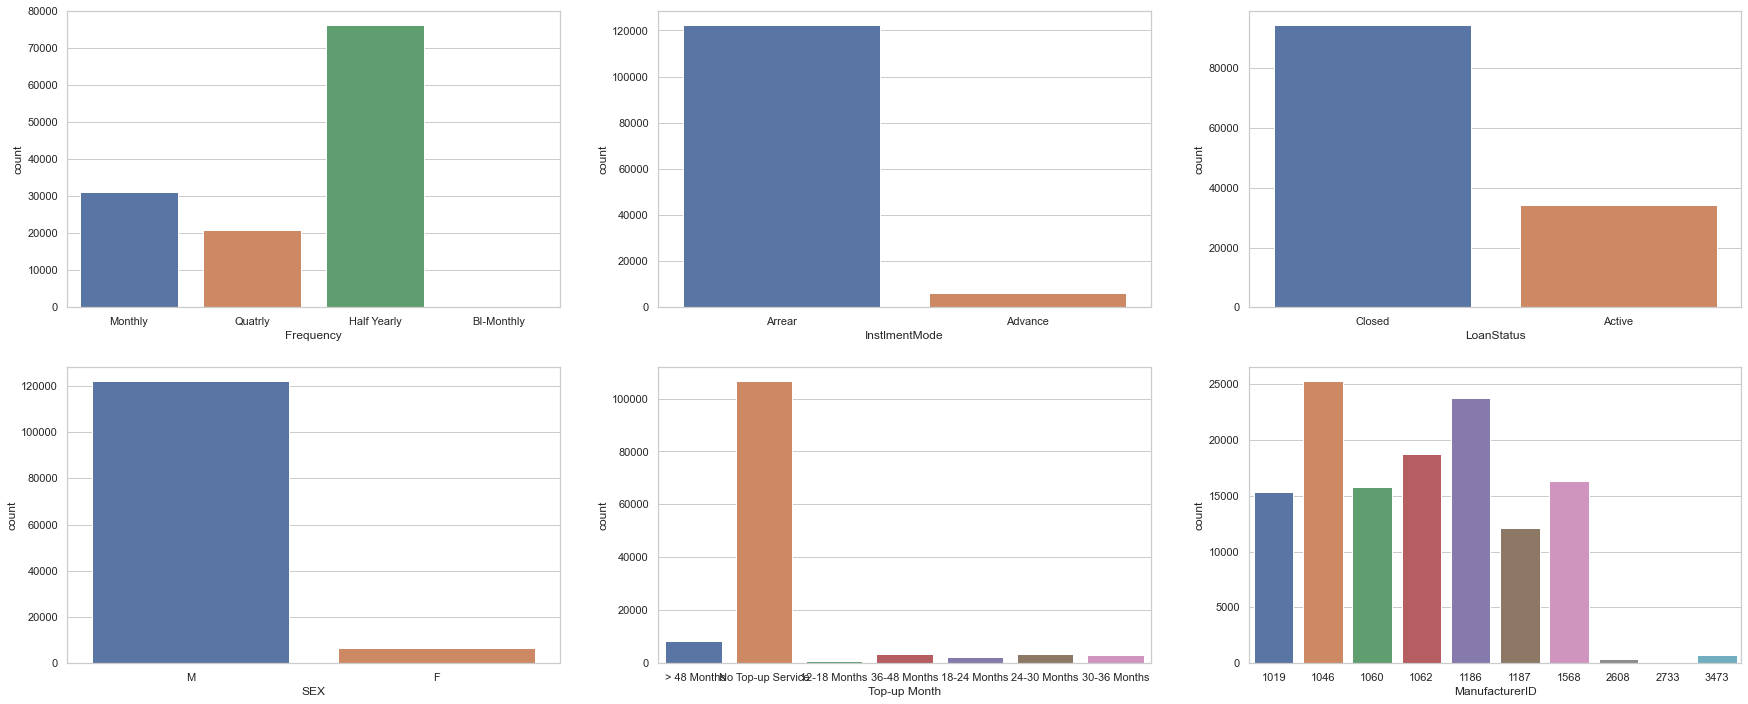

In [41]:
fig, axes = plt.subplots((len(low_cardinality_features)//3), 3, figsize=(30, 12))
sns.set_style("whitegrid")

i = 0
for triaxis in axes:
    for axis in triaxis:
        sns.countplot(x=low_cardinality_features[i], data=train_df, ax=axis);
        i = i+1
        if i == len(low_cardinality_features):
            break

Thus we can infer some points from this data:-
* Most people (by volume) pay their installments on a half-yearly basis.
* Majority of loans (by volume) are paid off as Arrear rather than in advance.
* Males have taken more loans tha Females (by volume).

Out of curiosity let's check what is the Top-Up Month pattern fopr each Sex.

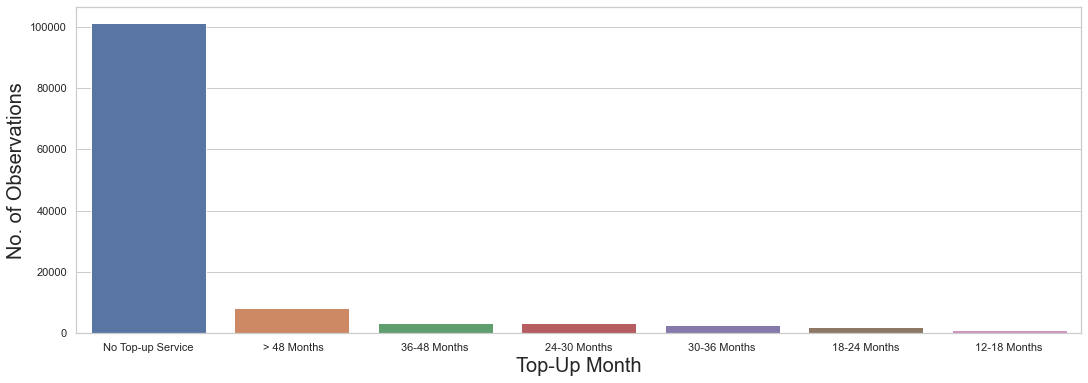

In [42]:
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
sns.countplot(x='Top-up Month', data=train_df[train_df['SEX'] == 'M'],
              order = train_df[train_df['SEX'] == 'M']['Top-up Month'].value_counts().index);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Top-Up Month", size=20);

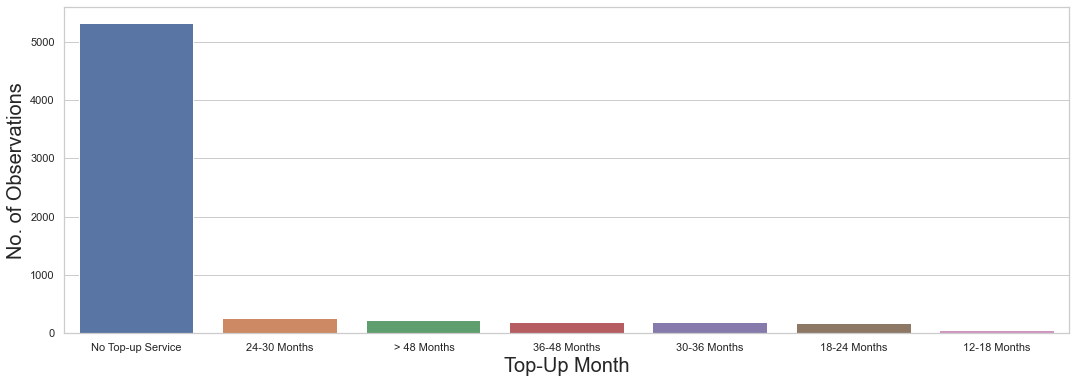

In [43]:
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
sns.countplot(x='Top-up Month', data=train_df[train_df['SEX'] == 'F'],
              order = train_df[train_df['SEX'] == 'F']['Top-up Month'].value_counts().index);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Top-Up Month", size=20);

We can roughly say that Females tend to take Top-Up loans earlier compared to Males (If they have decided to take).  
Let's check the same thing with InstalmentMode :-

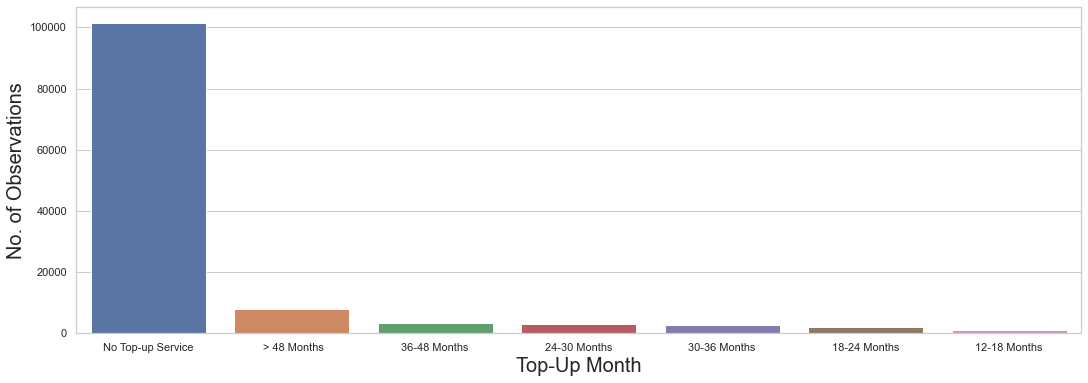

In [44]:
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
sns.countplot(x='Top-up Month', data=train_df[train_df['InstlmentMode'] == 'Arrear'],
              order = train_df[train_df['InstlmentMode'] == 'Arrear']['Top-up Month'].value_counts().index);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Top-Up Month", size=20);

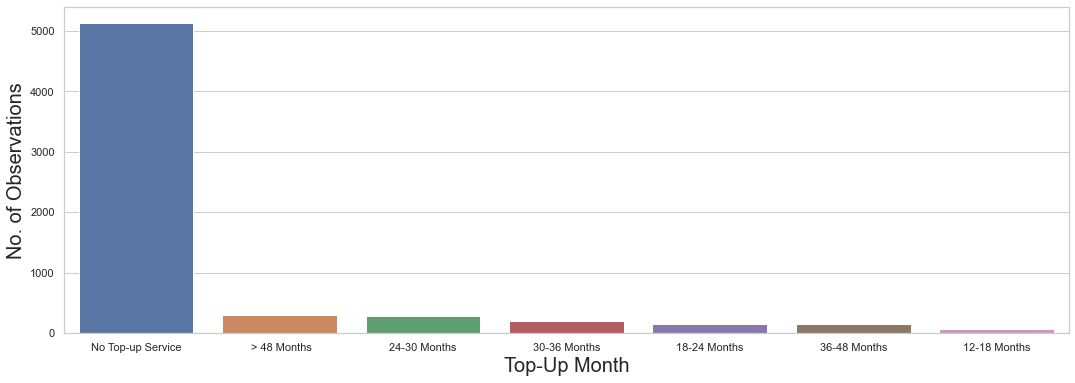

In [45]:
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
sns.countplot(x='Top-up Month', data=train_df[train_df['InstlmentMode'] == 'Advance'],
              order = train_df[train_df['InstlmentMode'] == 'Advance']['Top-up Month'].value_counts().index);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Top-Up Month", size=20);

We can infer from this that irrespective of InstalmentMode, It has a very little effect on probability/tenure of taking a Top-Up loan.

## 3. Date-Time Features:-  

In [46]:
target_variables = list(train_df['Top-up Month'].unique())

In [47]:
temp_df = train_df.copy()
temp_df['Disbursal Date'] = temp_df['DisbursalDate'].astype('datetime64[M]')
temp_df['Maturity Date'] = temp_df['MaturityDAte'].astype('datetime64[M]')
temp_df['Auth Date'] = temp_df['AuthDate'].astype('datetime64[M]')

In [48]:
data1 = temp_df.groupby(['Disbursal Date','Top-up Month']).size().reset_index(name='counts')
data2 = temp_df.groupby(['Disbursal Date']).size().reset_index(name='Full_Count')
data = data1.set_index('Disbursal Date').join(data2.set_index('Disbursal Date'))
data['Ratio'] = data['counts']/data['Full_Count']

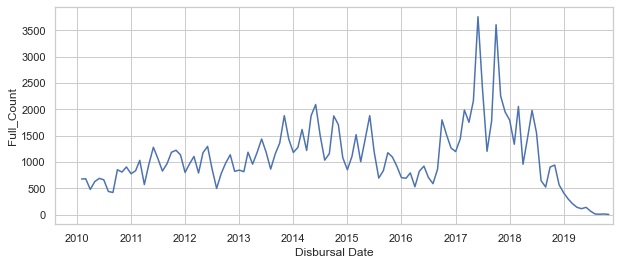

In [49]:
ax = plt.subplots(figsize=(10, 4))
plot = sns.lineplot(data=data2, x='Disbursal Date', y='Full_Count');
plot.set_xlim(right='2019-12-01');

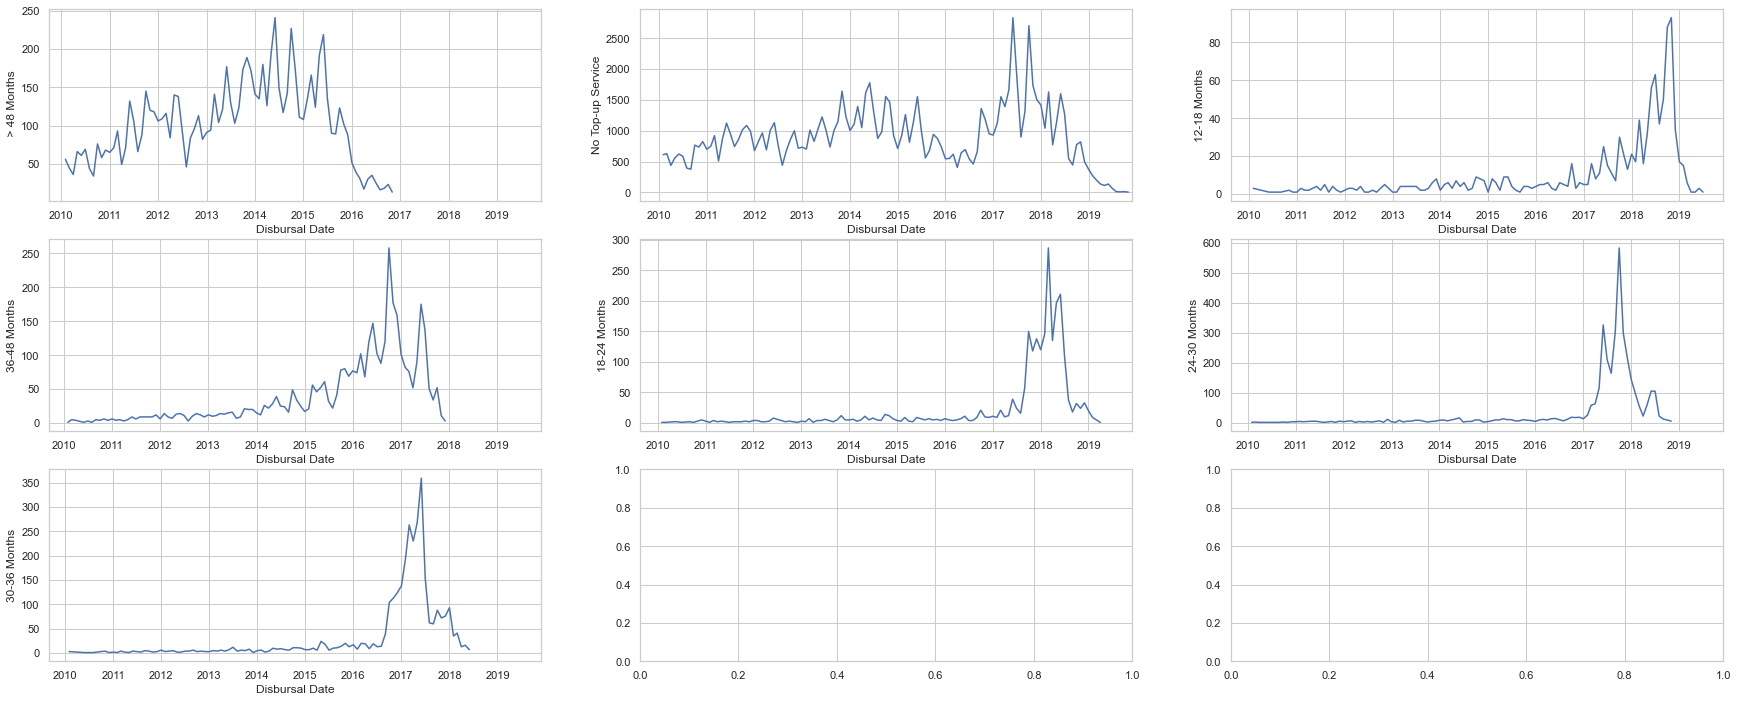

In [50]:
fig, axes = plt.subplots((len(target_variables)//3)+1, 3, figsize=(30, 12))
sns.set_style("whitegrid")

i = 0
for triaxis in axes:
    for axis in triaxis:
        sns.lineplot(data=data[data['Top-up Month']==target_variables[i]], x='Disbursal Date', y='counts', ax=axis);
        axis.set_ylabel(target_variables[i]);
        axis.set_xlim(right='2019-12-01')
        i = i+1
        if i == len(target_variables):
            break

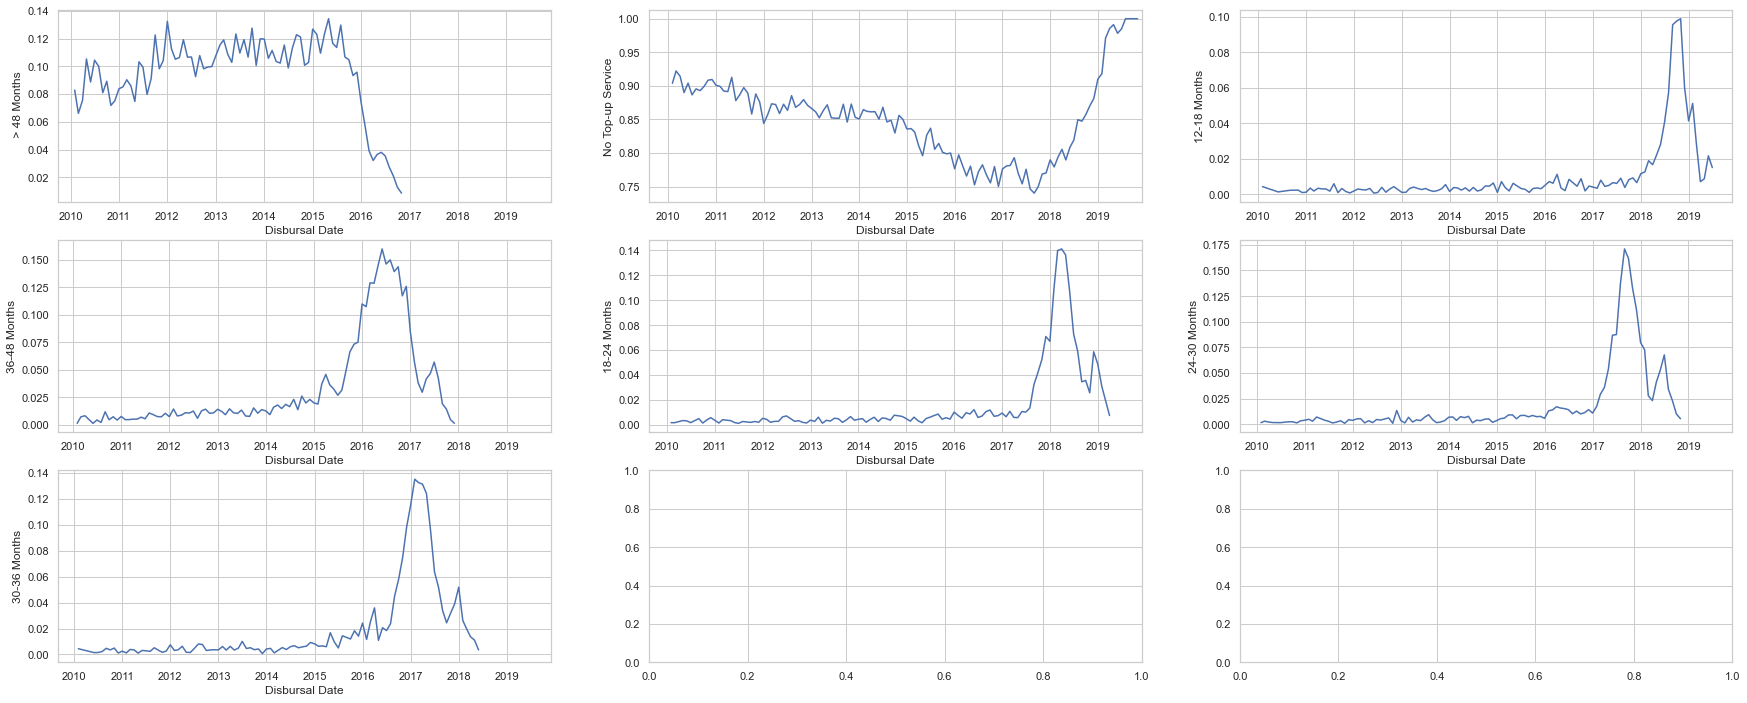

In [51]:
fig, axes = plt.subplots((len(target_variables)//3)+1, 3, figsize=(30, 12))
sns.set_style("whitegrid")

i = 0
for triaxis in axes:
    for axis in triaxis:
        sns.lineplot(data=data[data['Top-up Month']==target_variables[i]], x='Disbursal Date', y='Ratio', ax=axis);
        axis.set_ylabel(target_variables[i]);
        axis.set_xlim(right='2019-12-01')
        i = i+1
        if i == len(target_variables):
            break

We can roughly say that, when sorted by the Disbursal Date

In [52]:
data1 = temp_df.groupby(['Maturity Date','Top-up Month']).size().reset_index(name='counts')
data2 = temp_df.groupby(['Maturity Date']).size().reset_index(name='Full_Count')
data = data1.set_index('Maturity Date').join(data2.set_index('Maturity Date'))
data['Ratio'] = data['counts']/data['Full_Count']

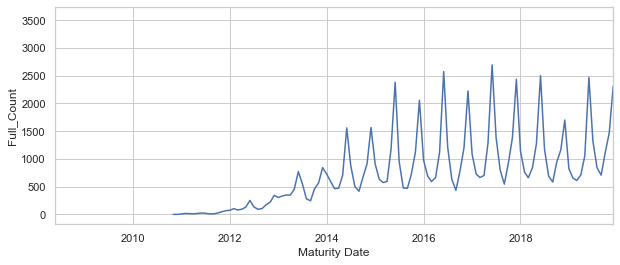

In [53]:
ax = plt.subplots(figsize=(10, 4))
plot = sns.lineplot(data=data2, x='Maturity Date', y='Full_Count');
plot.set_xlim(right='2019-12-01');

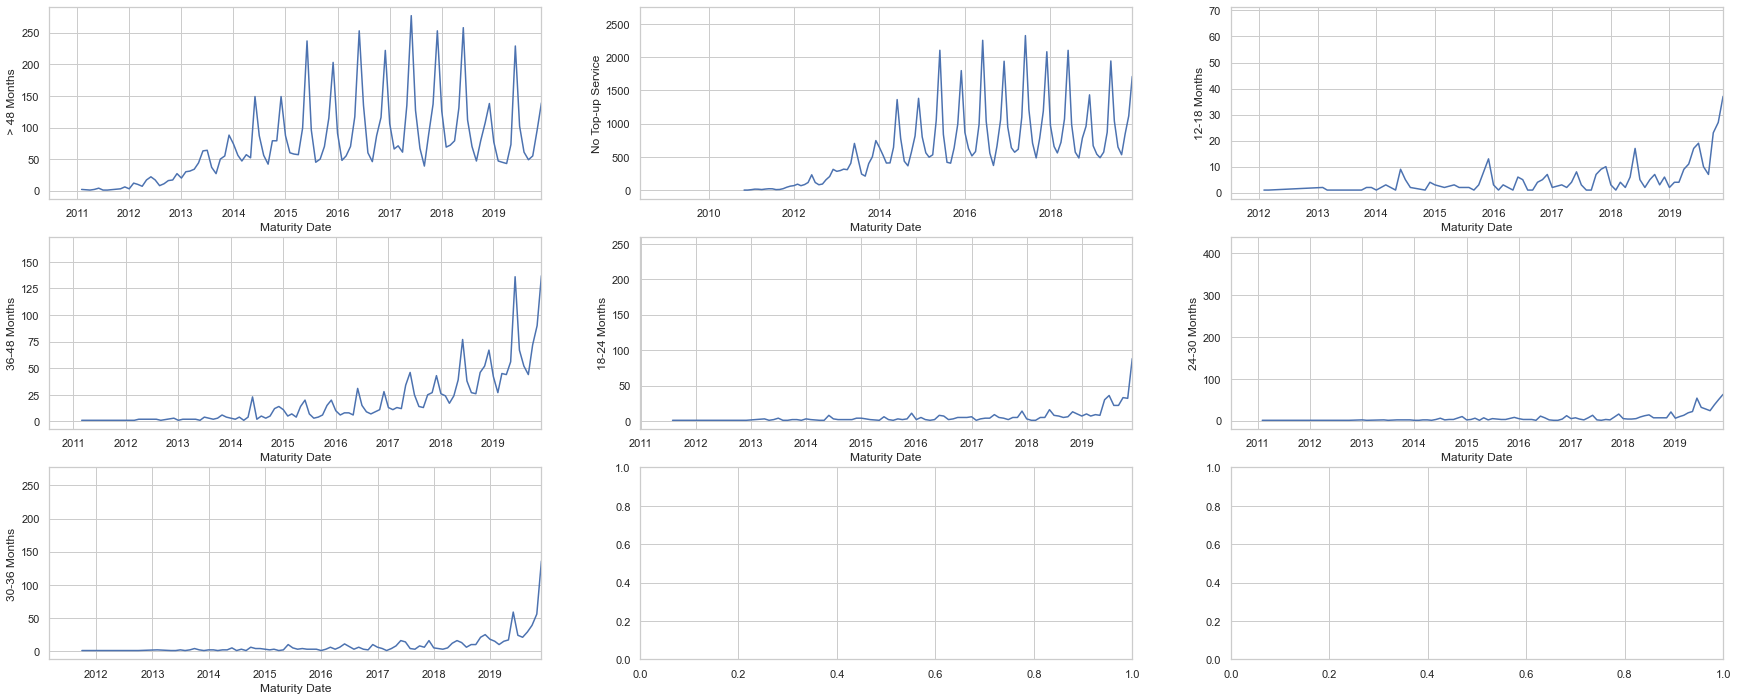

In [54]:
fig, axes = plt.subplots((len(target_variables)//3)+1, 3, figsize=(30, 12))
sns.set_style("whitegrid")

i = 0
for triaxis in axes:
    for axis in triaxis:
        sns.lineplot(data=data[data['Top-up Month']==target_variables[i]], x='Maturity Date', y='counts', ax=axis);
        axis.set_ylabel(target_variables[i]);
        axis.set_xlim(right='2019-12-01')
        i = i+1
        if i == len(target_variables):
            break

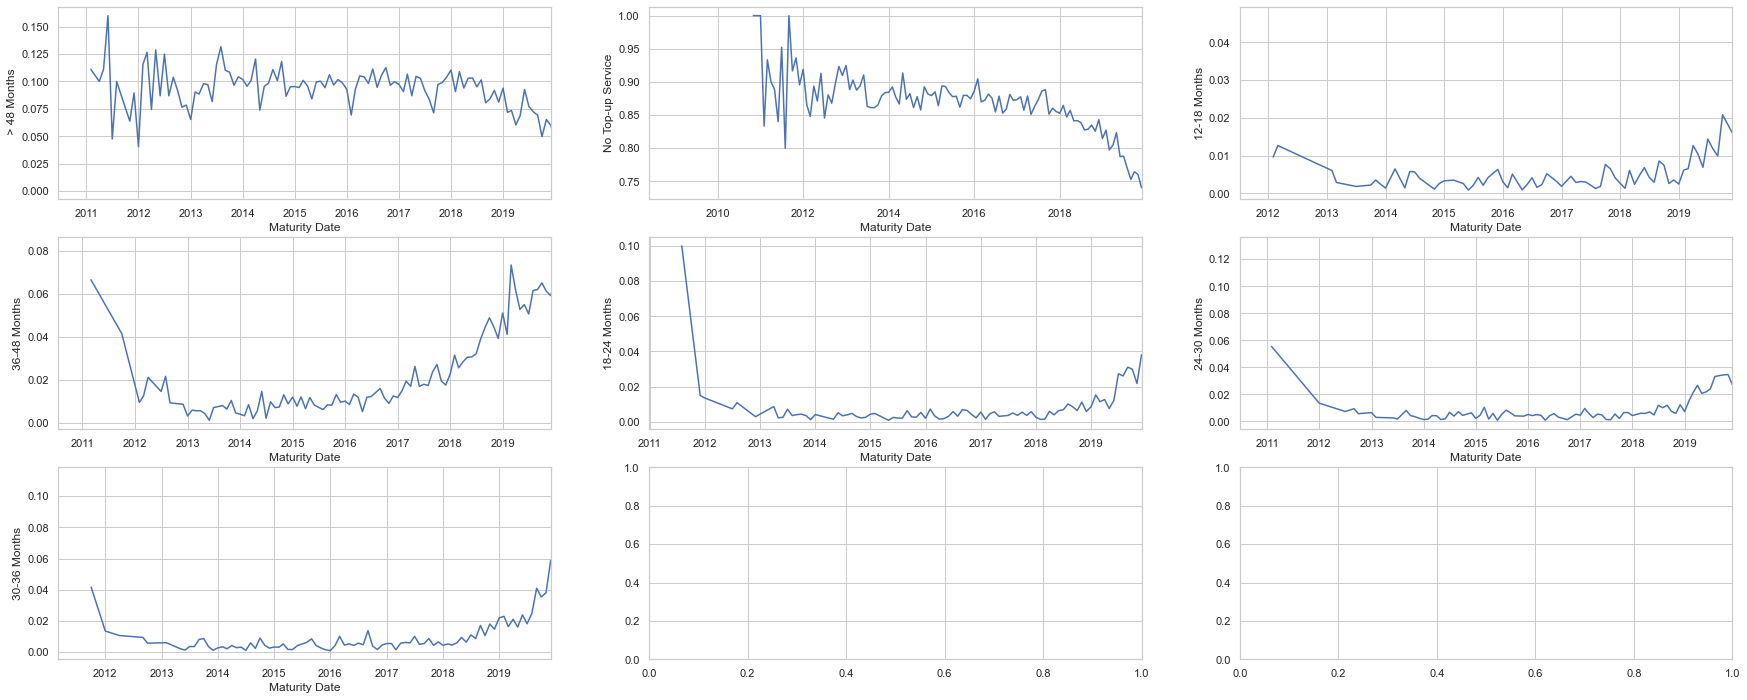

In [55]:
fig, axes = plt.subplots((len(target_variables)//3)+1, 3, figsize=(30, 12))
sns.set_style("whitegrid")

i = 0
for triaxis in axes:
    for axis in triaxis:
        sns.lineplot(data=data[data['Top-up Month']==target_variables[i]], x='Maturity Date', y='Ratio', ax=axis);
        axis.set_ylabel(target_variables[i]);
        axis.set_xlim(right='2019-12-01')
        i = i+1
        if i == len(target_variables):
            break

In [56]:
data1 = temp_df.groupby(['Auth Date','Top-up Month']).size().reset_index(name='counts')
data2 = temp_df.groupby(['Auth Date']).size().reset_index(name='Full_Count')
data = data1.set_index('Auth Date').join(data2.set_index('Auth Date'))
data['Ratio'] = data['counts']/data['Full_Count']

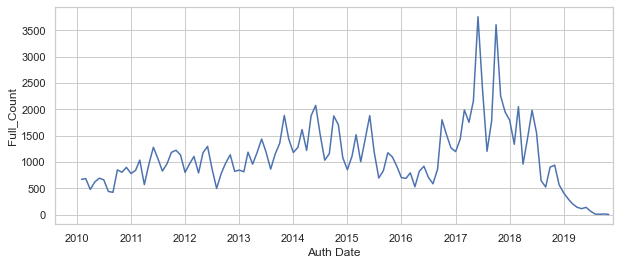

In [57]:
ax = plt.subplots(figsize=(10, 4))
plot = sns.lineplot(data=data2, x='Auth Date', y='Full_Count');
plot.set_xlim(right='2019-12-01');

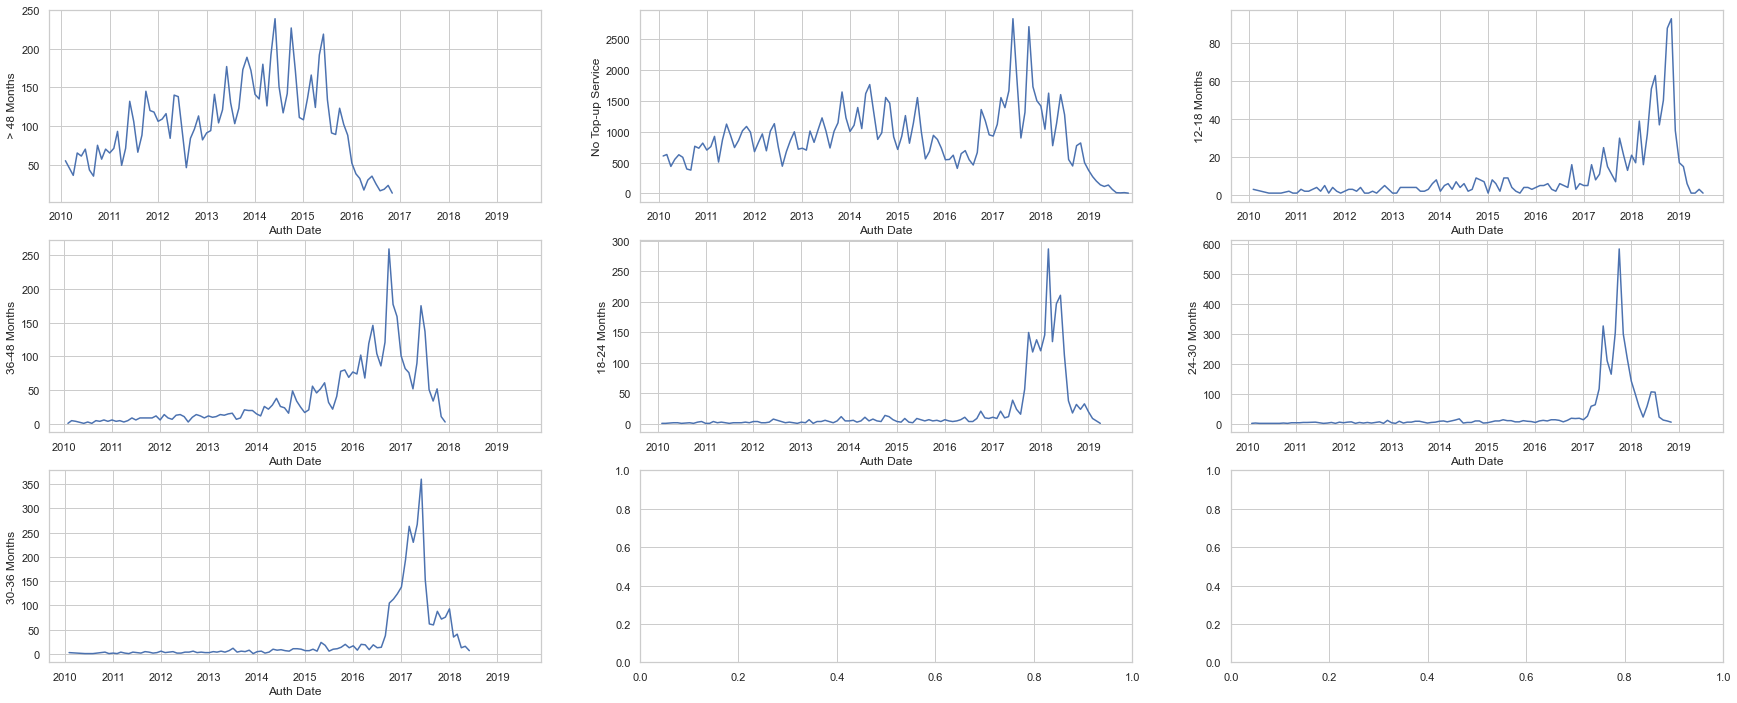

In [58]:
fig, axes = plt.subplots((len(target_variables)//3)+1, 3, figsize=(30, 12))
sns.set_style("whitegrid")

i = 0
for triaxis in axes:
    for axis in triaxis:
        sns.lineplot(data=data[data['Top-up Month']==target_variables[i]], x='Auth Date', y='counts', ax=axis);
        axis.set_ylabel(target_variables[i]);
        axis.set_xlim(right='2019-12-01')
        i = i+1
        if i == len(target_variables):
            break

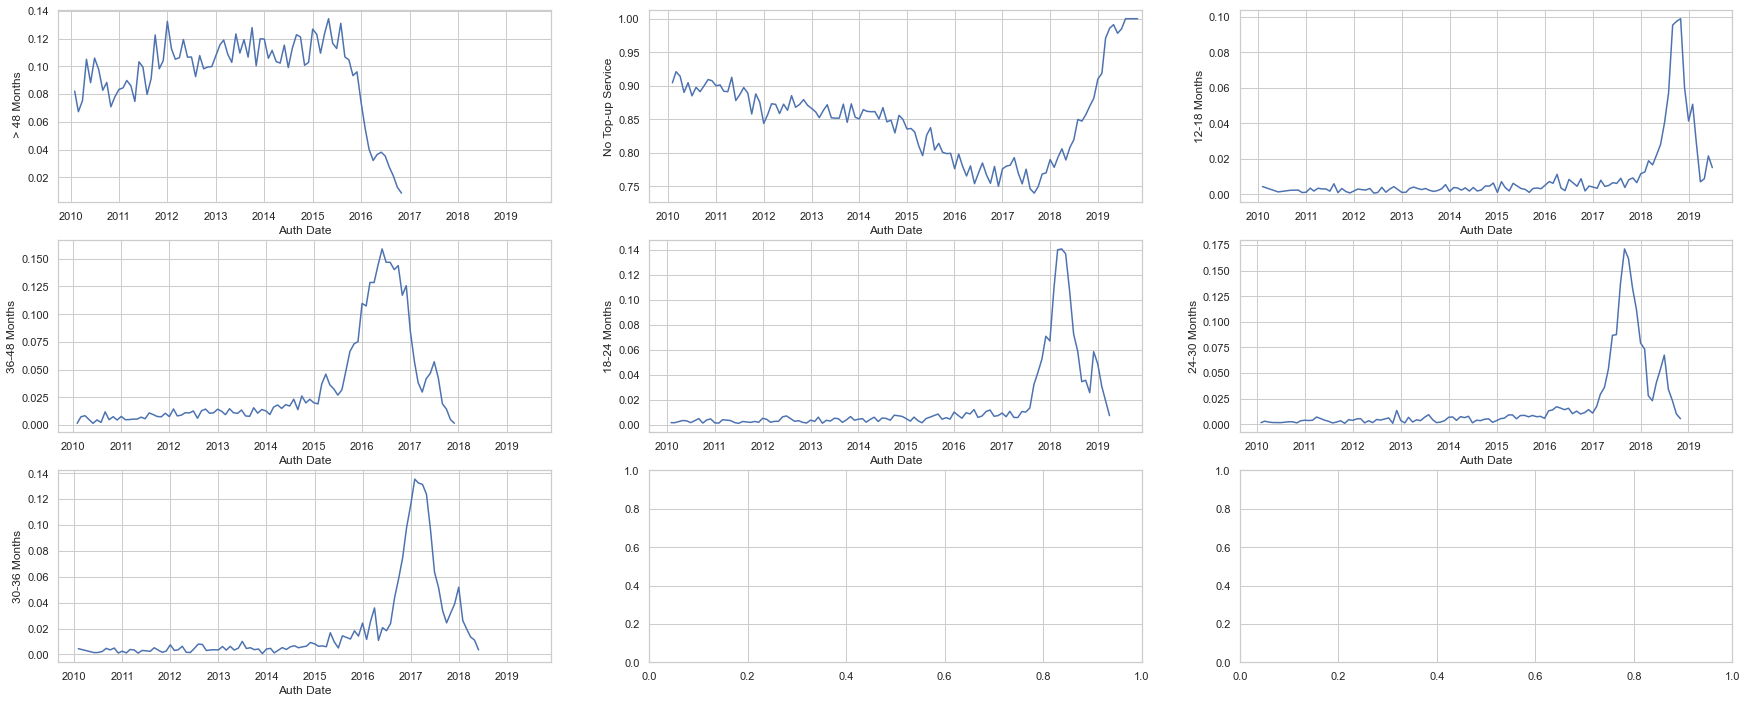

In [59]:
fig, axes = plt.subplots((len(target_variables)//3)+1, 3, figsize=(30, 12))
sns.set_style("whitegrid")

i = 0
for triaxis in axes:
    for axis in triaxis:
        sns.lineplot(data=data[data['Top-up Month']==target_variables[i]], x='Auth Date', y='Ratio', ax=axis);
        axis.set_ylabel(target_variables[i]);
        axis.set_xlim(right='2019-12-01')
        i = i+1
        if i == len(target_variables):
            break

After seeing the above visualizations, we can infer the following:-  
* There has been a steep decline of loans disbursed by this provider since Mid-2018.
* There has been an gradual decline in top-up loans ratio to number-of-loans from this provider since mid 2017.
* Earlier the most frequent top-up-loan decision interval was >48 months, but recently people have started taking top-up-loans earlier, ie 24-30 months (incase they take).

<h1 align="center"><ins><font color='darkblue'>Feature Engineering</font></ins></h1>

## 1. Null Values Imputation:-  
NaN values are a often a red-flag for most of the Machine-Learning Algorithms. So, before we proceed further we need to find and impute the NaN values with something suitable.

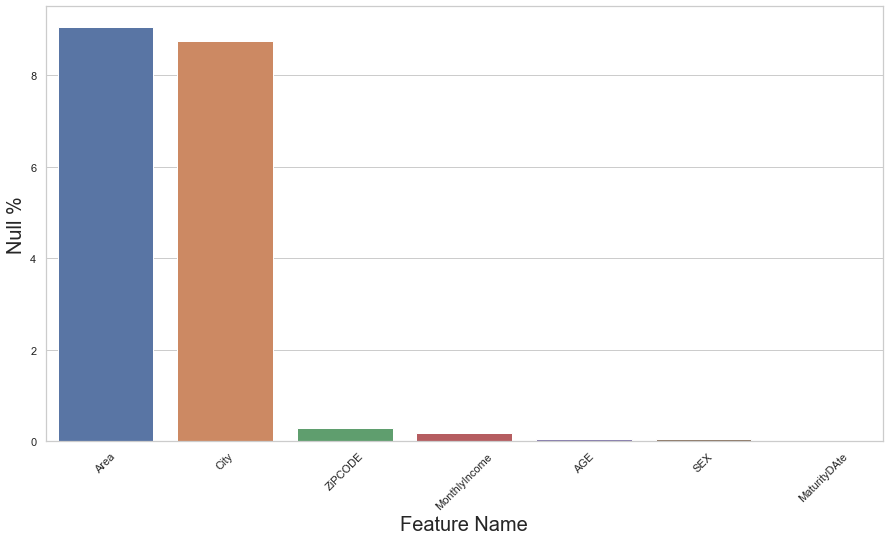

There are 7 features with missing values in the training data.


In [60]:
nulls_train = np.sum(train_df.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)
nullcols_train = nullcols_train.apply(lambda x: 100*x/train_df.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
plt.xticks(rotation=45)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()
print('There are', len(nullcols_train), 'features with missing values in the training data.')

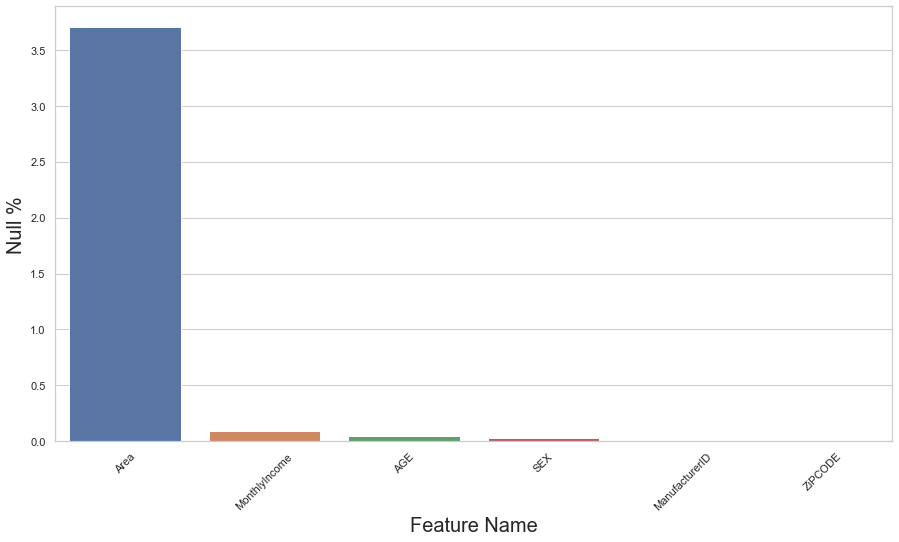

There are 6 features with missing values in the test data.


In [61]:
nulls_test = np.sum(test_df.isnull())
nullcols_test = nulls_test.loc[(nulls_test != 0)].sort_values(ascending=False)
nullcols_test = nullcols_test.apply(lambda x: 100*x/test_df.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
plt.xticks(rotation=45)
sns.barplot(x=nullcols_test.index, y=nullcols_test)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()
print('There are', len(nullcols_test), 'features with missing values in the test data.')

The following strategy can be implemented to impute the mising values for each of the features:-
1. Area, City, ZIPCODE, ManufacturerID and SEX are Categorical variables, so we can impute them with thge most common value of their respective features since it is only a very small % of the total volume and using other sophisticaded imputation algorithms like Clustering will have minimal ROI.
2. Monthly Income and AGE are continuous variables, but again the null % is very low, so we can safely impute them by the average from their respective columns.
3. Maturity date is something we can logically calculate by taking average loan period (maturity date - disbursement date) and adding it to the disbursement date.

In [62]:
train_df['Area'] = train_df['Area'].fillna(train_df['Area'].mode().iloc[0])
train_df['City'] = train_df['City'].fillna(train_df['City'].mode().iloc[0])
train_df['SEX'] = train_df['SEX'].fillna(train_df['SEX'].mode().iloc[0])
train_df['ZiPCODE'] = train_df.groupby('City')['ZiPCODE'].ffill()

train_df['MonthlyIncome'] = train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].mean())
train_df['AGE'] = train_df['AGE'].fillna(train_df['AGE'].mean())

mean_delta = (train_df['DisbursalDate'] - train_df['MaturityDAte']).mean()
train_df['MaturityDAte'] = train_df['MaturityDAte'].fillna(train_df['DisbursalDate'] + mean_delta)

In [63]:
test_df['Area'] = test_df['Area'].fillna(test_df['Area'].mode().iloc[0])
test_df['SEX'] = test_df['SEX'].fillna(test_df['SEX'].mode().iloc[0])
test_df['ManufacturerID'] = test_df['ManufacturerID'].fillna(test_df['ManufacturerID'].mode().iloc[0])
test_df['ZiPCODE'] = test_df.groupby('City')['ZiPCODE'].bfill()

test_df['MonthlyIncome'] = test_df['MonthlyIncome'].fillna(test_df['MonthlyIncome'].mean())
test_df['AGE'] = test_df['AGE'].fillna(test_df['AGE'].mean())

## 2. Converting Features to correct format:-  

In [64]:
continuous_features = numerical_continuous_features
categorical_features = other_features

In [65]:
print(continuous_features)
print(categorical_features)
print(datetime_features)

['Tenure', 'AssetCost', 'AmountFinance', 'DisbursalAmount', 'EMI', 'LTV', 'AGE', 'MonthlyIncome', 'DISBURSED-AMT/HIGH CREDIT_bureau', 'CURRENT-BAL_bureau', 'OVERDUE-AMT_bureau', 'WRITE-OFF-AMT_bureau', 'CUR BAL_Hist_Sum_bureau', 'AMT OVERDUE_Hist_Sum_bureau', 'AMT PAID_Hist_Sum_bureau', 'SELF-INDICATOR_False_bureau', 'SELF-INDICATOR_True_bureau', 'MATCH-TYPE_PRIMARY_bureau', 'MATCH-TYPE_SECONDARY_bureau', 'ACCT-TYPE_Auto Loan (Personal)_bureau', 'ACCT-TYPE_Business Loan Priority Sector  Agriculture_bureau', 'ACCT-TYPE_Commercial Vehicle Loan_bureau', 'ACCT-TYPE_Gold Loan_bureau', 'ACCT-TYPE_Kisan Credit Card_bureau', 'ACCT-TYPE_Other_bureau', 'ACCT-TYPE_REST_bureau', 'ACCT-TYPE_Tractor Loan_bureau', 'CONTRIBUTOR-TYPE_COP_bureau', 'CONTRIBUTOR-TYPE_NAB_bureau', 'CONTRIBUTOR-TYPE_NBF_bureau', 'CONTRIBUTOR-TYPE_PRB_bureau', 'CONTRIBUTOR-TYPE_REST_bureau', 'CONTRIBUTOR-TYPE_RRB_bureau', 'OWNERSHIP-IND_Guarantor_bureau', 'OWNERSHIP-IND_Individual_bureau', 'OWNERSHIP-IND_Joint_bureau', 'OWNE

In [66]:
for col in test_df.columns:
    if (col not in continuous_features) and (col not in datetime_features):
        train_df[col] = train_df[col].astype('object')
        test_df[col] = test_df[col].astype('object')

In [67]:
train_df['Topup_Binary'] = train_df['Top-up Month'].apply(lambda x : 0 if x == 'No Top-up Service' else 1)

## 3. Categorical Values Encoding:-  
First Let's map the Target Variable to suitable numerical Feature. For this I have decided to take the Mean value of the 'Top-up Month' as the class.

In [68]:
mask = {' > 48 Months' : 48,
        'No Top-up Service' : 0,
        '12-18 Months' : 15,
        '36-48 Months' : 42,
        '18-24 Months' : 21,
        '24-30 Months' : 27,
        '30-36 Months' : 33}

In [69]:
train_df['Top-up Month Encoded'] = train_df['Top-up Month'].map(mask)

We can convert the low-cardinality categorical features to one-hot encoding and encode the high-cardinality categorical features by LabelEncoder or a target based encoder like CatBoost Encoder.

In [70]:
low_cardinality_features = []
high_cardinality_features = []

for col in categorical_features:
    if col != 'Top-up Month':
        if train_df[col].nunique() < 11:
            low_cardinality_features.append(col)
        else:
            high_cardinality_features.append(col)
        
print(f'Low Cardinality Features: {low_cardinality_features}')
print(f'High Cardinality Features: {high_cardinality_features}')

Low Cardinality Features: ['Frequency', 'InstlmentMode', 'LoanStatus', 'SEX', 'ManufacturerID']
High Cardinality Features: ['PaymentMode', 'Area', 'City', 'State', 'BranchID', 'AssetID', 'SupplierID', 'ZiPCODE']


Now let's **One-Hot encode** the Low-Cardinality Features:-

In [71]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(train_df[low_cardinality_features]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_df[low_cardinality_features]))

OH_cols.index = train_df[low_cardinality_features].index
OH_cols_test.index = test_df[low_cardinality_features].index

print(OH_cols.shape)
print(OH_cols_test.shape)

(128655, 20)
(14745, 20)


In [72]:
train_df = train_df.drop(low_cardinality_features, axis=1)
test_df = test_df.drop(low_cardinality_features, axis=1)

train_df = pd.concat([train_df, OH_cols], axis=1)
test_df = pd.concat([test_df, OH_cols_test], axis=1)

Now we can **CatBoost Encode** the High-Cardinality Features:-

In [73]:
# Create the CatBoost encoder
cb_enc = ce.CatBoostEncoder(cols=high_cardinality_features)

# Learn encoding from the training set
cb_enc.fit(train_df[high_cardinality_features], train_df['Top-up Month Encoded'])

# Apply encoding to the train and validation sets as new columns
# Adding `_cb` as a suffix to the new columns
train_df = train_df.join(cb_enc.transform(train_df[high_cardinality_features]).add_suffix('_cb'))
test_df = test_df.join(cb_enc.transform(test_df[high_cardinality_features]).add_suffix('_cb'))

# Dropping the original Cells
train_df = train_df.drop(high_cardinality_features, axis=1)
test_df = test_df.drop(high_cardinality_features, axis=1)

In [74]:
train_df.head()

ID  Tenure  AssetCost  AmountFinance  DisbursalAmount      EMI  \
0  1      48     450000       275000.0         275000.0  24000.0   
1  2      47     485000       350000.0         350000.0  10500.0   
2  3      68     690000       519728.0         519728.0  38300.0   
3  7      48     480000       400000.0         400000.0  11600.0   
4  8      44     619265       440000.0         440000.0  15000.0   

  DisbursalDate MaturityDAte   AuthDate    LTV   AGE  MonthlyIncome  \
0    2012-02-10   2016-01-15 2012-02-10  61.11  49.0       35833.33   
1    2012-03-31   2016-02-15 2012-03-31  70.00  23.0         666.67   
2    2017-06-17   2023-02-10 2017-06-17  69.77  39.0       45257.00   
3    2013-11-29   2017-11-10 2013-11-29  80.92  24.0       20833.33   
4    2011-12-08   2015-07-05 2011-12-08  71.05  56.0       27313.67   

        Top-up Month  DISBURSED-AMT/HIGH CREDIT_bureau  CURRENT-BAL_bureau  \
0        > 48 Months                         2201352.0            618526.0   
1  No Top-up Service                        18117081.0          10349457.0   
2       12-18 Months                         3708369.0           2065165.0   
3        > 48 Months                         1272553.0            624000.0   
4       36-48 Months                         2025216.0            974119.0   

   OVERDUE-AMT_bureau  WRITE-OFF-AMT_bureau  CUR BAL_Hist_Sum_bureau  \
0             37873.0                   0.0               26538866.0   
1                 0.0                   0.0              148166021.0   
2            103490.0                   0.0               84027186.0   
3                 0.0                   0.0               19057982.0   
4             35185.0                   0.0               33567641.0   

   AMT OVERDUE_Hist_Sum_bureau  AMT PAID_Hist_Sum_bureau  \
0                     133531.0                      0.00   
1                      62654.0               22432902.00   
2                    1367236.0                1328572.98   
3                          0.0                      0.00   
4                     304647.0                 202930.00   

   SELF-INDICATOR_False_bureau  SELF-INDICATOR_True_bureau  \
0                            4                           5   
1                           12                           1   
2                           29                           2   
3                            2                           2   
4                            6                           1   

   MATCH-TYPE_PRIMARY_bureau  MATCH-TYPE_SECONDARY_bureau  \
0                          9                            0   
1                         13                            0   
2                         31                            0   
3                          4                            0   
4                          7                            0   

   ACCT-TYPE_Auto Loan (Personal)_bureau  \
0                                      5   
1                                      1   
2                                      0   
3                                      0   
4                                      0   

   ACCT-TYPE_Business Loan Priority Sector  Agriculture_bureau  \
0                                                  0             
1                                                  0             
2                                                  0             
3                                                  0             
4                                                  0             

   ACCT-TYPE_Commercial Vehicle Loan_bureau  ACCT-TYPE_Gold Loan_bureau  \
0                                         0                           0   
1                                         4                           0   
2                                         3                           8   
3                                         0                           0   
4                                         1                           0   

   ACCT-TYPE_Kisan Credit Card_bureau  ACCT-TYPE_O

## 4. Date-Time to Ordinal Values:-  
Some algorithms do not support raw date-time format for training, thus we need to create a numeric ordinal value from the datetime data.

In [75]:
for col in datetime_features:
    train_df[col] = train_df[col].map(datetime.toordinal)
    test_df[col] = test_df[col].map(datetime.toordinal)

## 5. Synthetic Features Creation:-  
As discussed earlier, we can safely drop AmountFinance; because it is most of the times equal to DisbursalAmount. And in it's place we can create a synthetic Feature which addresses the deficit in the amount.

In [76]:
train_df['Deficit'] = train_df['AmountFinance'] - train_df['DisbursalAmount']
test_df['Deficit'] = test_df['AmountFinance'] - test_df['DisbursalAmount']

In [77]:
train_df['EMItoIncome'] = train_df['EMI']/(train_df['MonthlyIncome'] + 0.01)
test_df['EMItoIncome'] = test_df['EMI']/(test_df['MonthlyIncome'] + 0.01)

train_df['AssettoIncome'] = train_df['AssetCost']/((train_df['MonthlyIncome']*12) + 0.01)
test_df['AssettoIncome'] = test_df['AssetCost']/((test_df['MonthlyIncome']*12) + 0.01)

train_df['DifferenceAmount'] = train_df['AmountFinance'] - train_df['DisbursalAmount']
test_df['DifferenceAmount'] = test_df['AmountFinance'] - test_df['DisbursalAmount']

train_df['YearsOfService'] = 60 - train_df['AGE']
test_df['YearsOfService'] = 60 - test_df['AGE']

In [78]:
train_df = train_df.drop(['AmountFinance'], axis=1)
test_df = test_df.drop(['AmountFinance'], axis=1)

## 6. Feature Selection:-  
As we can see there are a lot of features in the training set, and most likely not all of them will be instrumental in creating the model, hence we can train out model more efficiently and mitigate any chances of overfitting if we selected only the essential features for training.  
There are various ways to go about it.
1. Drop Categorical features which have very high cardinality or 1.
2. Perform Statistical tests to find out feature importance of each feature and select only the top N feature (N being a hyper parameter can be tuned later).
3. Use automatic feature selection algorithms to prune uncorrelated/unnecessary features.  
  
First let's check the cardinality of each feature:-

In [79]:
train_df.nunique()

ID                  128655
Tenure                 141
AssetCost             7835
DisbursalAmount      19412
EMI                  24323
                     ...  
Deficit               1378
EMItoIncome          89538
AssettoIncome        59146
DifferenceAmount      1378
YearsOfService          74
Length: 81, dtype: int64

In [80]:
print(list(train_df.columns))

['ID', 'Tenure', 'AssetCost', 'DisbursalAmount', 'EMI', 'DisbursalDate', 'MaturityDAte', 'AuthDate', 'LTV', 'AGE', 'MonthlyIncome', 'Top-up Month', 'DISBURSED-AMT/HIGH CREDIT_bureau', 'CURRENT-BAL_bureau', 'OVERDUE-AMT_bureau', 'WRITE-OFF-AMT_bureau', 'CUR BAL_Hist_Sum_bureau', 'AMT OVERDUE_Hist_Sum_bureau', 'AMT PAID_Hist_Sum_bureau', 'SELF-INDICATOR_False_bureau', 'SELF-INDICATOR_True_bureau', 'MATCH-TYPE_PRIMARY_bureau', 'MATCH-TYPE_SECONDARY_bureau', 'ACCT-TYPE_Auto Loan (Personal)_bureau', 'ACCT-TYPE_Business Loan Priority Sector  Agriculture_bureau', 'ACCT-TYPE_Commercial Vehicle Loan_bureau', 'ACCT-TYPE_Gold Loan_bureau', 'ACCT-TYPE_Kisan Credit Card_bureau', 'ACCT-TYPE_Other_bureau', 'ACCT-TYPE_REST_bureau', 'ACCT-TYPE_Tractor Loan_bureau', 'CONTRIBUTOR-TYPE_COP_bureau', 'CONTRIBUTOR-TYPE_NAB_bureau', 'CONTRIBUTOR-TYPE_NBF_bureau', 'CONTRIBUTOR-TYPE_PRB_bureau', 'CONTRIBUTOR-TYPE_REST_bureau', 'CONTRIBUTOR-TYPE_RRB_bureau', 'OWNERSHIP-IND_Guarantor_bureau', 'OWNERSHIP-IND_Indiv

We can see that ID (which is a categorical feature) has a very high cardinality and AssetID_cb (which is also a categorical feature) has a cardinality of 1. Thus they would not help the algorithm learn anything substantial. We can safely drop these features.

In [81]:
train_df = train_df.drop(['AssetID_cb'], axis=1)
test_df = test_df.drop(['AssetID_cb'], axis=1)

In [82]:
numerical_features = []
categorical_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'PaymentMode_cb', 'Area_cb',
                        'City_cb', 'State_cb', 'BranchID_cb', 'SupplierID_cb', 'ZiPCODE_cb']
for col in train_df.columns:
    if (col not in categorical_features) and (col not in ['Topup_Binary', 'Top-up Month Encoded', 'Top-up Month', 'ID']):
        numerical_features.append(col)

### A) Mutual Information

In [83]:
K = 20
fs = SelectKBest(score_func=mutual_info_classif, k=K)
train_df_selected = fs.fit_transform(train_df[numerical_features + categorical_features], train_df['Topup_Binary'])
col_names = numerical_features + categorical_features
mask = SelectKBest.get_support(fs)
selected_features_mi_binary = []
for bool, feature in zip(mask, col_names):
    if bool:
        selected_features_mi_binary.append(feature)
print(selected_features_mi_binary)

['DISBURSED-AMT/HIGH CREDIT_bureau', 'CURRENT-BAL_bureau', 'CUR BAL_Hist_Sum_bureau', 'AMT PAID_Hist_Sum_bureau', 'SELF-INDICATOR_False_bureau', 'SELF-INDICATOR_True_bureau', 'MATCH-TYPE_PRIMARY_bureau', 'ACCT-TYPE_Gold Loan_bureau', 'ACCT-TYPE_REST_bureau', 'ACCT-TYPE_Tractor Loan_bureau', 'CONTRIBUTOR-TYPE_NAB_bureau', 'CONTRIBUTOR-TYPE_NBF_bureau', 'OWNERSHIP-IND_Individual_bureau', 'ACCOUNT-STATUS_Active_bureau', 'ACCOUNT-STATUS_Closed_bureau', 5, 7, 9, 'SupplierID_cb', 'ZiPCODE_cb']


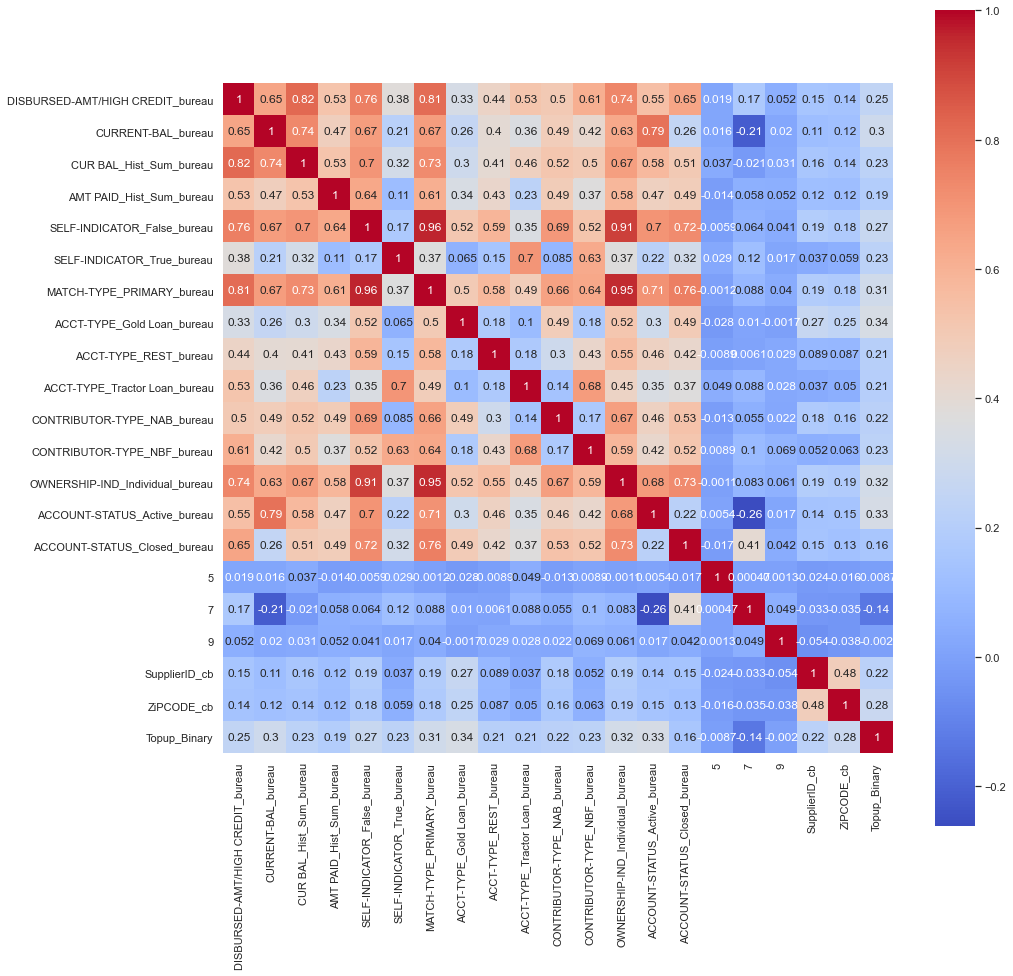

In [84]:
train_df_cor_spear = train_df[selected_features_mi_binary + ['Topup_Binary']].corr(method='spearman')
plt.figure(figsize=(15,15))
sns.heatmap(train_df_cor_spear,square=True,cmap='coolwarm', annot=True);

In [85]:
rest_df = train_df[train_df['Topup_Binary'] == 1]
K = 15
fs = SelectKBest(score_func=mutual_info_classif, k=K)
rest_df_selected = fs.fit_transform(rest_df[numerical_features + categorical_features], rest_df['Top-up Month Encoded'])
col_names = numerical_features + categorical_features
mask = SelectKBest.get_support(fs)
selected_features_mi_multi = []
for bool, feature in zip(mask, col_names):
    if bool:
        selected_features_mi_multi.append(feature)
print(selected_features_mi_multi)

['Tenure', 'AssetCost', 'DisbursalAmount', 'DisbursalDate', 'MaturityDAte', 'AuthDate', 'DISBURSED-AMT/HIGH CREDIT_bureau', 'ACCOUNT-STATUS_Closed_bureau', 6, 7, 'PaymentMode_cb', 'City_cb', 'BranchID_cb', 'SupplierID_cb', 'ZiPCODE_cb']


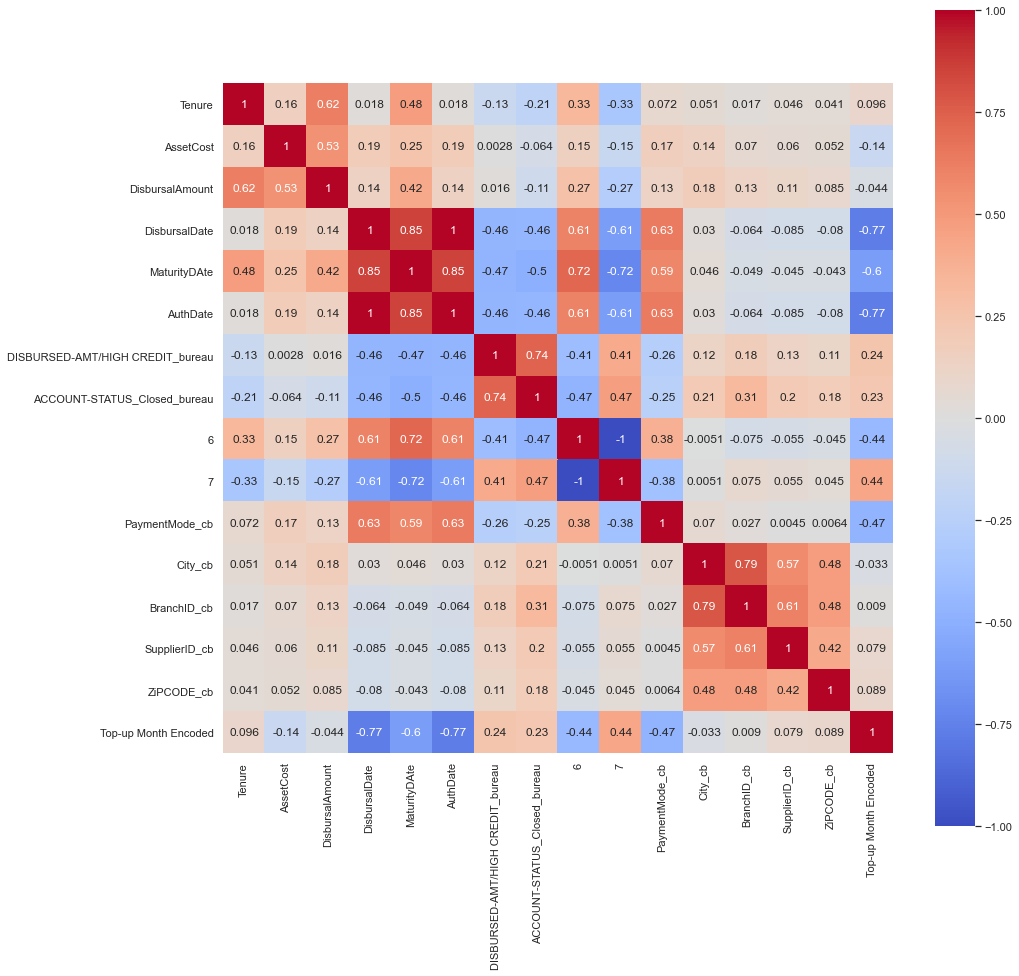

In [86]:
rest_df_cor_spear = rest_df[selected_features_mi_multi + ['Top-up Month Encoded']].corr(method='spearman')
plt.figure(figsize=(15,15))
sns.heatmap(rest_df_cor_spear,square=True,cmap='coolwarm', annot=True);

<h1 align="center" style='color: white; background-color: #be2830'>Model Creation</h1>

This problem can be breadly classified into 2 problems:-  
1. Binary classification problem which determines if the account holder will ever take a Top-Up Loan or not.
2. Multi-Class classification into the tenure if he is probabilistic to take a Top-Up loan
 
As a thumb-rule, I follow the following chronology of modelling (For both the cases) (in ascending order of complexity) for such type of problems:-  
1. Logistic Regression
2. Naive Bayes
3. k-NN
4. SVC (multi_class= 'crammer_singer')
5. Random Forest
6. Gradient Boosting
7. Neural Networks  
  
Before Creating models, let's first establish a wrapper function that fits the classifiers and evaluates the model performance based on decided metrics.

<h1 align="center"><ins><font color='darkblue'>Binary Classification Model Creation</font></ins></h1>

In [87]:
RANDOM_SEED = 0

def rate_model(clf, x, y, cv = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED)):
    '''
    Prints out various evaluation metrics for a classification task. Like:-
    1. Classification Accuracy
    2. Precision
    3. Recall
    4. F1 Score
    5. Confusion matrix
    6. Classification Report
    6. Classification Report
    All score are calculated in base format. No averaging is performed.
    
    clf - Classification Model
    x - Input features
    y - Input labels
    cv - Cross Validation criteria
    random_state - Random Seed
    '''
    scoring = {'acc' : 'accuracy', 'precision' : 'precision_macro', 'recall' : 'recall_macro', 'f1' : 'f1_macro'}
    scores = cross_validate(clf, x, y, scoring=scoring, cv=cv, return_train_score=False)
    acc = np.mean(scores['test_acc'])
    prec = np.mean(scores['test_precision'])
    rec = np.mean(scores['test_recall'])
    f1 = np.mean(scores['test_f1'])
    print(f'Accuracy: {acc}')
    print(f'Precision Macro: {prec}')
    print(f'Recall Macro: {rec}')
    print(f'F1 Macro-Score: {f1}')
    print()
    X_train, X_valid, y_train, y_valid = train_test_split(x, y,
                                                          test_size = 0.2,
                                                          random_state = RANDOM_SEED,
                                                          stratify=y,
                                                          shuffle=True)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_valid)
    print('Confusion Matrix:-')
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(y_valid, predictions), annot=True, fmt='g', cmap="YlGnBu")
    plt.show()
    result1 = classification_report(y_valid, predictions)
    print('Classification Report:-')
    print (result1)

Now let's focus on creating the binary classification model which determines if the acount holder is ever likely to take a top-up loan.

## 1. Logistic Regression:- 

Accuracy: 0.8184835412537407
Precision Macro: 0.5635019758482058
Recall Macro: 0.5114739266799637
F1 Macro-Score: 0.4887831746621039

Confusion Matrix:-


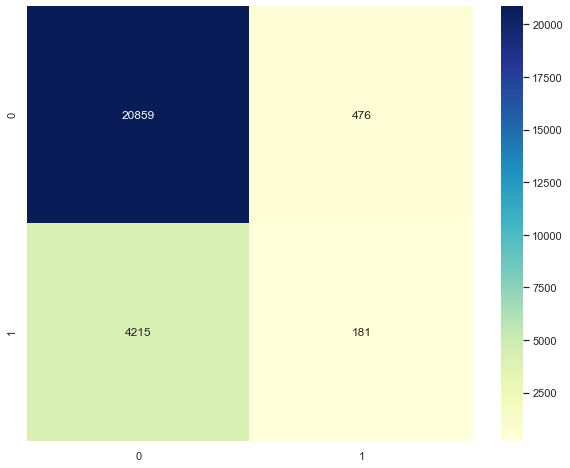

Classification Report:-
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     21335
           1       0.28      0.04      0.07      4396

    accuracy                           0.82     25731
   macro avg       0.55      0.51      0.49     25731
weighted avg       0.74      0.82      0.76     25731



In [88]:
clf = LogisticRegression(C=1.0)
rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

## 2. Multinomial Naive Bayes:- 

In [89]:
# clf = MultinomialNB()
# rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

## 3. k-NN:- 

Accuracy: 0.7892192297229024
Precision Macro: 0.5817477176108596
Recall Macro: 0.5555299006812671
F1 Macro-Score: 0.5614233244426201

Confusion Matrix:-


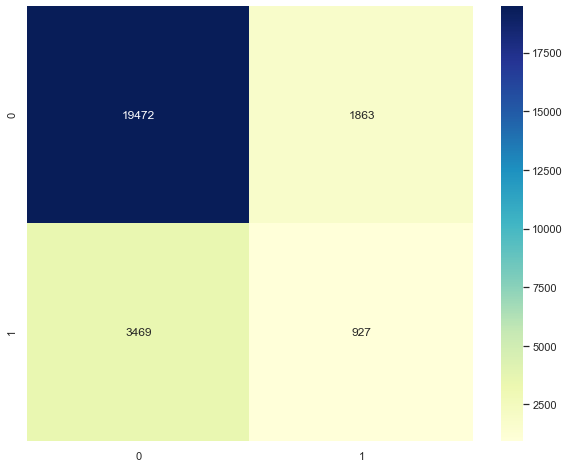

Classification Report:-
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     21335
           1       0.33      0.21      0.26      4396

    accuracy                           0.79     25731
   macro avg       0.59      0.56      0.57     25731
weighted avg       0.76      0.79      0.77     25731



In [90]:
clf = KNeighborsClassifier(n_neighbors=3)
rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

## 4. SVC:- 

In [91]:
# clf = SVC(C=1.0)
# rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

## 5. Random Forest:-

Accuracy: 0.8744549376238778
Precision Macro: 0.8124929764256119
Recall Macro: 0.7036020001603862
F1 Macro-Score: 0.7358338312674547

Confusion Matrix:-


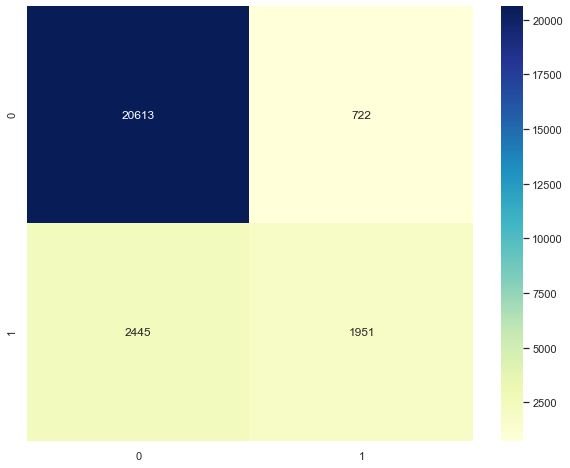

Classification Report:-
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     21335
           1       0.73      0.44      0.55      4396

    accuracy                           0.88     25731
   macro avg       0.81      0.70      0.74     25731
weighted avg       0.87      0.88      0.86     25731



In [92]:
clf = RandomForestClassifier(n_estimators = 100,
                             random_state=RANDOM_SEED,
                             n_jobs=10)
rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

## 6. XGBoost:-

In [93]:
# clf = xgb.XGBClassifier(max_depth=7,
#                         n_estimators=200,
#                         colsample_bytree=0.8,
#                         subsample=0.8,
#                         nthread=10,
#                         learning_rate=0.1)
# rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

<h1 align="center"><ins><font color='darkblue'>Hyper-Parameter Tuning for Binary Classification</font></ins></h1>

## 1. Logistic Regression:- 

In [94]:
# n_iter = 200
# cross_val_kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# def hyperopt_train_test(params, cv=cross_val_kf, X=train_df[selected_features_mi_binary], y=train_df['Topup_Binary']):
#     clf = LogisticRegression(**params)
#     return cross_val_score(clf, X, y, cv=cv, scoring='f1_macro', n_jobs=10).mean()

# def call_hyperopt(params):
#     acc = hyperopt_train_test(params)
#     return {'loss': -acc, 'status': STATUS_OK}

# space4lr = {'penalty': hp.choice('penalty', ['l2']),
#             'C': hp.uniform('C', 0.01, 100),
#             'fit_intercept': hp.choice('fit_intercept', [True, False]),
#             'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear'])}

# trials = Trials()
# best = fmin(fn = call_hyperopt, space = space4lr, algo = tpe.suggest, max_evals = n_iter, trials = trials)

In [95]:
# print(best)

In [96]:
# clf = LogisticRegression(C=15.460730132827978, fit_intercept=False, penalty='l2', solver='newton-cg')
# rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

## 2. Multinomial Naive Bayes:- 

The performance of Multinomial NB was too bad to begin with, and since it has too few hyper-parameters to tune, there is nothing much we can do to improve the performance of this algorithm. So I decided to drop this algorithm and not use it for final predictions.

## 3. k-NN:- 

In [97]:
# n_iter = 200
# cross_val_kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# def hyperopt_train_test(params, cv=cross_val_kf, X=train_df[selected_features_mi_binary], y=train_df['Topup_Binary']):
#     clf = KNeighborsClassifier(**params)
#     return cross_val_score(clf, X, y, cv=cv, scoring='f1_macro', n_jobs=10).mean()

# def call_hyperopt(params):
#     acc = hyperopt_train_test(params)
#     return {'loss': -acc, 'status': STATUS_OK}

# space4knn = {'n_neighbors': hp.choice('n_neighbors', np.arange(1, 9, dtype=int)), 
#             'p': hp.choice('p', [1, 2]),
#             'weights': hp.choice('weights', ['uniform', 'distance'])}

# trials = Trials()
# best = fmin(fn = call_hyperopt, space = space4knn, algo = tpe.suggest, max_evals = n_iter, trials = trials)

In [98]:
# print(best)

Accuracy: 0.7553767828689131
Precision Macro: 0.5653877804646597
Recall Macro: 0.5640232143231471
F1 Macro-Score: 0.564565003440068

Confusion Matrix:-


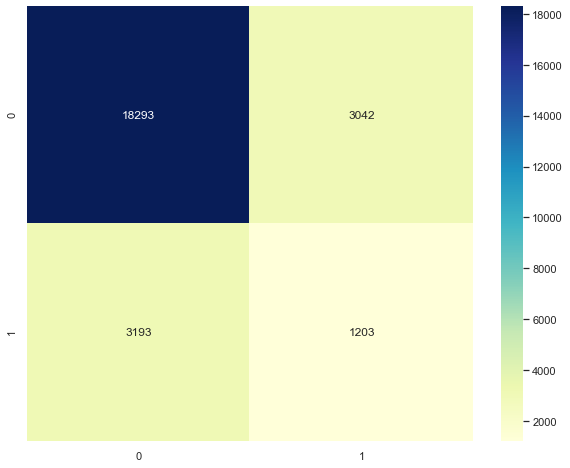

Classification Report:-
              precision    recall  f1-score   support

           0       0.85      0.86      0.85     21335
           1       0.28      0.27      0.28      4396

    accuracy                           0.76     25731
   macro avg       0.57      0.57      0.57     25731
weighted avg       0.75      0.76      0.76     25731



In [99]:
clf = KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')
rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

## 4. SVC:- 

In [100]:
# n_iter = 200
# cross_val_kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# def hyperopt_train_test(params, cv=cross_val_kf, X=train_df[selected_features_mi_binary], y=train_df['Topup_Binary']):
#     clf = SVC(**params)
#     return cross_val_score(clf, X, y, cv=cv, scoring='f1_macro', n_jobs=10).mean()

# def call_hyperopt(params):
#     acc = hyperopt_train_test(params)
#     return {'loss': -acc, 'status': STATUS_OK}

# space4svc = {'C': hp.uniform('C', 1, 80),
# #              'gamma': hp.choice('gamma', ['auto', 'scale']),
# #              'kernel': hp.choice('kernel', ['rbf']),
#              'degree': hp.choice('degree', np.arange(1, 9, dtype=int))
#             }

# trials = Trials()
# best = fmin(fn = call_hyperopt, space = space4svc, algo = tpe.suggest, max_evals = n_iter, trials = trials)

In [101]:
# print(best)

## 5. Random Forest:- 

In [102]:
# n_iter = 50
# cross_val_kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# def hyperopt_train_test(params, cv=cross_val_kf, X=train_df[selected_features_mi_binary], y=train_df['Topup_Binary']):
#     clf = RandomForestClassifier(**params)
#     return cross_val_score(clf, X, y, cv=cv, scoring='f1_macro', n_jobs=10).mean()

# def call_hyperopt(params):
#     acc = hyperopt_train_test(params)
#     return {'loss': -acc, 'status': STATUS_OK}

# space4rf = {'n_estimators': hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
#             'max_depth': hp.choice('max_depth', [None] + list(np.linspace(3, 20).astype(int))),
#             'max_features': hp.choice('max_features', ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))),
#             'max_leaf_nodes': hp.choice('max_leaf_nodes', [None] + list(np.linspace(10, 50).astype(int))),
#             'min_samples_split': hp.choice('min_samples_split', np.arange(2, 10, dtype=int)),
#             'bootstrap': hp.choice('bootstrap', [True, False]),
#             'random_state' : hp.choice('random_state', [RANDOM_SEED]),
#             'n_jobs' : hp.choice('n_jobs', [10])
#             }

# trials = Trials()
# best = fmin(fn = call_hyperopt, space = space4rf, algo = tpe.suggest, max_evals = n_iter, trials = trials)

In [103]:
# print(best)

Accuracy: 0.8740041195445183
Precision Macro: 0.8053617388545448
Recall Macro: 0.7124335718399943
F1 Macro-Score: 0.741638904345912

Confusion Matrix:-


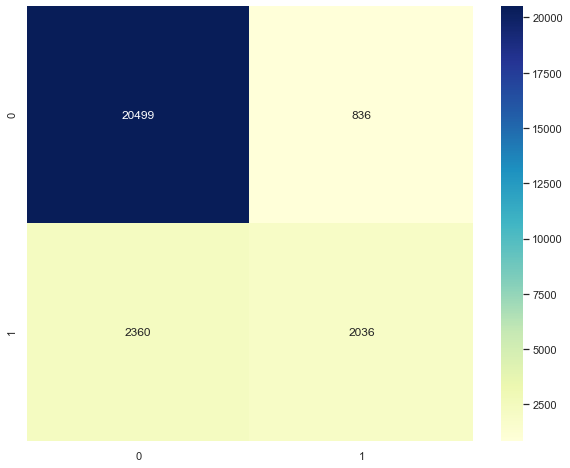

Classification Report:-
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     21335
           1       0.71      0.46      0.56      4396

    accuracy                           0.88     25731
   macro avg       0.80      0.71      0.74     25731
weighted avg       0.86      0.88      0.86     25731



In [104]:
clf = RandomForestClassifier(bootstrap=True,
                             max_depth=20,
                             max_features=0.9,
                             max_leaf_nodes=None,
                             min_samples_split=7,
                             n_estimators=258,
                             n_jobs=10,
                             random_state=RANDOM_SEED)
rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

## 5. XGBoost:- 

In [105]:
# n_iter = 100
# cross_val_kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# def hyperopt_train_test(params, cv=cross_val_kf, X=train_df[selected_features_mi_binary], y=train_df['Topup_Binary']):
#     clf = xgb.XGBClassifier(max_depth = int(params['max_depth']),
#                             n_estimators = int(params['n_estimators']),
#                             learning_rate = params['learning_rate'],
#                             colsample_bytree = params['colsample_bytree'],
#                             subsample = params['subsample'],
#                             nthread = 10)
#     return cross_val_score(clf, X, y, cv=cv, scoring='f1_macro', n_jobs=10).mean()

# def call_hyperopt(params):
#     acc = hyperopt_train_test(params)
#     return {'loss': -acc, 'status': STATUS_OK}

# space4xgb = {'max_depth': hp.uniform('max_depth', 1, 15),
#              'n_estimators': hp.uniform('n_estimators', 2, 500),
#              'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.99),
#              'subsample': hp.uniform('subsample', 0.1, 0.99),
#              'learning_rate': hp.uniform('learning_rate', 0.001, 10)}

# trials = Trials()
# best = fmin(fn = call_hyperopt, space = space4xgb, algo = tpe.suggest, max_evals = n_iter, trials = trials)

In [106]:
# print(best)

C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[22:44:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[22:46:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix:-


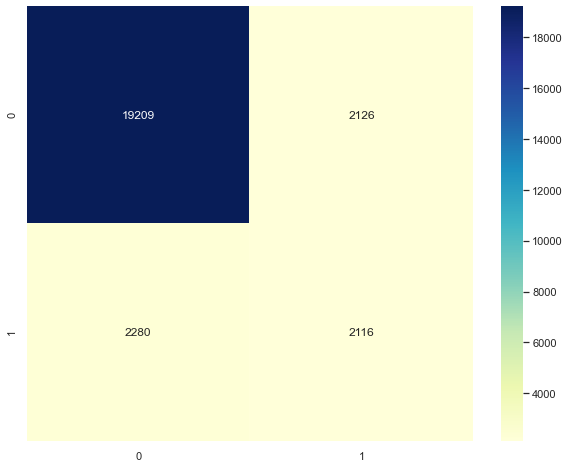

Classification Report:-
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     21335
           1       0.50      0.48      0.49      4396

    accuracy                           0.83     25731
   macro avg       0.70      0.69      0.69     25731
weighted avg       0.83      0.83      0.83     25731



In [107]:
clf = xgb.XGBClassifier(colsample_bytree=0.4792787103232488,
                        learning_rate=1.7358105977056868,
                        max_depth=9,
                        n_estimators=152,
                        subsample=0.8524845091171285)
rate_model(clf, train_df[selected_features_mi_binary], train_df['Topup_Binary'])

<h1 align="center"><ins><font color='darkblue'>Multi-Class Classification Model Creation</font></ins></h1>

## 1. Multinomial NB:- 

In [108]:
# clf = MultinomialNB()
# rate_model(clf, train_df[train_df['Topup_Binary'] == 1][selected_features_mi_multi],
#            train_df[train_df['Topup_Binary'] == 1]['Top-up Month Encoded'])

## 2. KNN:- 

Accuracy: 0.27358975633034893
Precision Macro: 0.213103692235752
Recall Macro: 0.21451492378911613
F1 Macro-Score: 0.20632356403166857

Confusion Matrix:-


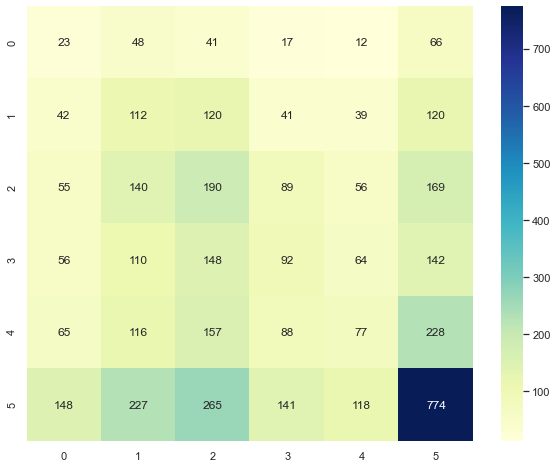

Classification Report:-
              precision    recall  f1-score   support

          15       0.06      0.11      0.08       207
          21       0.15      0.24      0.18       474
          27       0.21      0.27      0.23       699
          33       0.20      0.15      0.17       612
          42       0.21      0.11      0.14       731
          48       0.52      0.46      0.49      1673

    accuracy                           0.29      4396
   macro avg       0.22      0.22      0.22      4396
weighted avg       0.31      0.29      0.29      4396



In [109]:
clf = KNeighborsClassifier(n_neighbors=3)
rate_model(clf, train_df[train_df['Topup_Binary'] == 1][selected_features_mi_multi],
           train_df[train_df['Topup_Binary'] == 1]['Top-up Month Encoded'])

## 3. Random Forest:- 

Accuracy: 0.6586139328234065
Precision Macro: 0.6216987997855878
Recall Macro: 0.5576483333055442
F1 Macro-Score: 0.57479502617729

Confusion Matrix:-


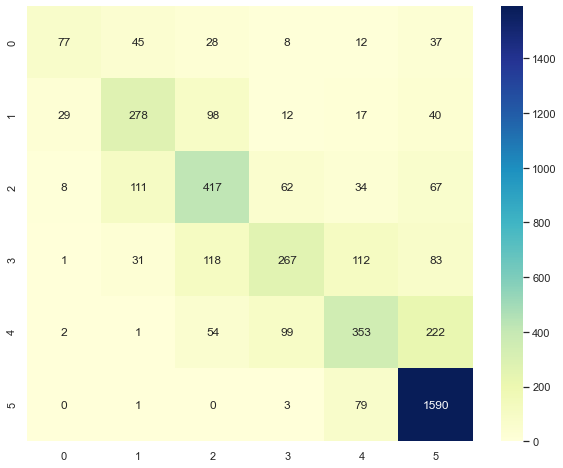

Classification Report:-
              precision    recall  f1-score   support

          15       0.66      0.37      0.48       207
          21       0.60      0.59      0.59       474
          27       0.58      0.60      0.59       699
          33       0.59      0.44      0.50       612
          42       0.58      0.48      0.53       731
          48       0.78      0.95      0.86      1673

    accuracy                           0.68      4396
   macro avg       0.63      0.57      0.59      4396
weighted avg       0.66      0.68      0.66      4396



In [110]:
clf = RandomForestClassifier(n_estimators = 100,
                             random_state=RANDOM_SEED,
                             n_jobs=10,
                             class_weight='balanced')
rate_model(clf, train_df[train_df['Topup_Binary'] == 1][selected_features_mi_multi],
           train_df[train_df['Topup_Binary'] == 1]['Top-up Month Encoded'])

## 4. XGBoost:- 

[22:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[22:46:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:46:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:47:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:47:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

C:\Anaconda3\envs\ML\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Confusion Matrix:-


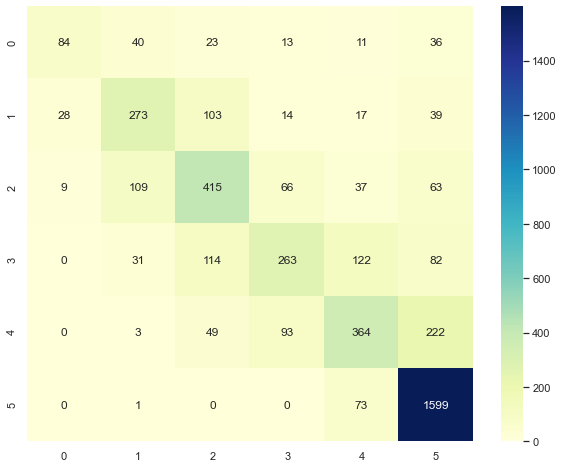

Classification Report:-
              precision    recall  f1-score   support

          15       0.69      0.41      0.51       207
          21       0.60      0.58      0.59       474
          27       0.59      0.59      0.59       699
          33       0.59      0.43      0.50       612
          42       0.58      0.50      0.54       731
          48       0.78      0.96      0.86      1673

    accuracy                           0.68      4396
   macro avg       0.64      0.58      0.60      4396
weighted avg       0.67      0.68      0.67      4396



In [111]:
clf = xgb.XGBClassifier(max_depth=7,
                        n_estimators=200,
                        colsample_bytree=0.8,
                        subsample=0.8,
                        nthread=10,
                        learning_rate=0.1)
rate_model(clf, train_df[train_df['Topup_Binary'] == 1][selected_features_mi_multi],
           train_df[train_df['Topup_Binary'] == 1]['Top-up Month Encoded'])

<h1 align="center"><ins><font color='darkblue'>Hyper-Parameter Tuning for Multi-Class Classification</font></ins></h1>

In [112]:
# n_iter = 100
# cross_val_kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# def hyperopt_train_test(params, cv=cross_val_kf, X=train_df[train_df['Topup_Binary'] == 1][selected_features_mi_multi],
#                         y=train_df[train_df['Topup_Binary'] == 1]['Top-up Month Encoded']):
#     clf = RandomForestClassifier(**params)
#     return cross_val_score(clf, X, y, cv=cv, scoring='f1_macro', n_jobs=10).mean()

# def call_hyperopt(params):
#     acc = hyperopt_train_test(params)
#     return {'loss': -acc, 'status': STATUS_OK}

# space4rf = {'n_estimators': hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
#             'max_depth': hp.choice('max_depth', [None] + list(np.linspace(3, 20).astype(int))),
#             'max_features': hp.choice('max_features', ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))),
#             'max_leaf_nodes': hp.choice('max_leaf_nodes', [None] + list(np.linspace(10, 50).astype(int))),
#             'min_samples_split': hp.choice('min_samples_split', np.arange(2, 10, dtype=int)),
#             'bootstrap': hp.choice('bootstrap', [True, False]),
#             'random_state' : hp.choice('random_state', [RANDOM_SEED]),
#             'n_jobs' : hp.choice('n_jobs', [10]),
#             'class_weight' : hp.choice('class_weight', [None, 'balanced'])
#             }

# trials = Trials()
# best = fmin(fn = call_hyperopt, space = space4rf, algo = tpe.suggest, max_evals = n_iter, trials = trials)

In [113]:
# print(best)

Accuracy: 0.6671228058189211
Precision Macro: 0.6364242361860468
Recall Macro: 0.5670064521204009
F1 Macro-Score: 0.58496467603232

Confusion Matrix:-


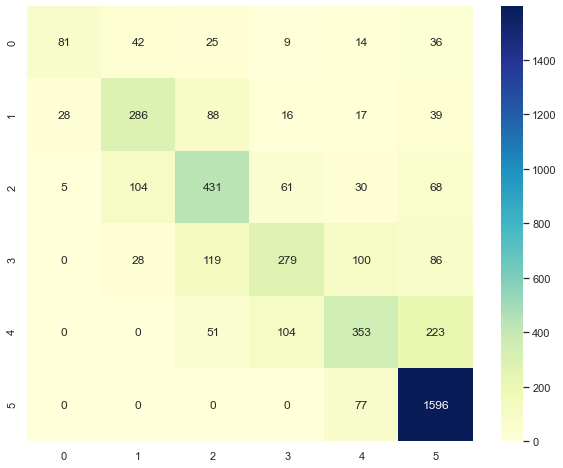

Classification Report:-
              precision    recall  f1-score   support

          15       0.71      0.39      0.50       207
          21       0.62      0.60      0.61       474
          27       0.60      0.62      0.61       699
          33       0.59      0.46      0.52       612
          42       0.60      0.48      0.53       731
          48       0.78      0.95      0.86      1673

    accuracy                           0.69      4396
   macro avg       0.65      0.58      0.61      4396
weighted avg       0.68      0.69      0.67      4396



In [114]:
clf = RandomForestClassifier(bootstrap=True,
                             max_depth=13,
                             max_features='sqrt',
                             max_leaf_nodes=None,
                             min_samples_split=5,
                             n_estimators=470,
                             n_jobs=10,
                             random_state=RANDOM_SEED)
rate_model(clf, train_df[train_df['Topup_Binary'] == 1][selected_features_mi_multi],
           train_df[train_df['Topup_Binary'] == 1]['Top-up Month Encoded'])

<h1 align="center" style='color: white; background-color: #be2830'>Submission Prediction</h1>

In [115]:
def score_bi_model(clf_binary, clf_multi, train_df=train_df, features_binary=selected_features_mi_binary,
                   features_multi=selected_features_mi_multi):
    X_train, X_valid, y_train, y_valid = train_test_split(train_df,
                                                          train_df[['Topup_Binary', 'Top-up Month Encoded']],
                                                          test_size = 0.3,
                                                          random_state = RANDOM_SEED,
                                                          stratify=train_df['Top-up Month Encoded'],
                                                          shuffle=True)
    clf_binary.fit(X_train[features_binary], y_train['Topup_Binary'])
    pred_binary = clf_binary.predict(X_valid[features_binary])
    binary_class = pd.DataFrame({'ID': X_valid['ID'],
                                 'Topup_Binary': pred_binary})
    binary_actual = X_valid['Topup_Binary']
    X_valid = X_valid.drop(['Topup_Binary'], axis=1)
    X_valid = X_valid.set_index('ID').join(binary_class.set_index('ID'))
    binary_pred = X_valid['Topup_Binary']
    
    print('Confusion Matrix:-')
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(binary_actual, binary_pred), annot=True, fmt='g', cmap="YlGnBu")
    plt.show()
    result1 = classification_report(binary_actual, binary_pred)
    print('Classification Report:-')
    print(result1)
    print('\n--------------------------------------------------------------------------------\n')
    
    clf_multi.fit(X_train[X_train['Topup_Binary'] == 1][features_multi],
                  y_train[X_train['Topup_Binary'] == 1]['Top-up Month Encoded'])
    pred_multi = clf_multi.predict(X_valid[X_valid['Topup_Binary'] == 1][features_multi])
    multi_class = pd.DataFrame({'ID': X_valid[X_valid['Topup_Binary'] == 1].index,
                                'Multi_Prediction': pred_multi})
    X_valid = X_valid.reset_index()
    X_valid = X_valid.set_index('ID').join(multi_class.set_index('ID'))
    X_valid = X_valid.reset_index()
    
    X_valid['Prediction'] = X_valid['Multi_Prediction']
    X_valid['Prediction'] = X_valid['Prediction'].fillna(X_valid['Topup_Binary'])
    
    final_pred = X_valid['Prediction']
    final_actual = y_valid['Top-up Month Encoded']
    
    print('Confusion Matrix:-')
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(final_actual, final_pred), annot=True, fmt='g', cmap="YlGnBu")
    plt.show()
    result1 = classification_report(final_actual, final_pred)
    print('Classification Report:-')
    print(result1)

Confusion Matrix:-


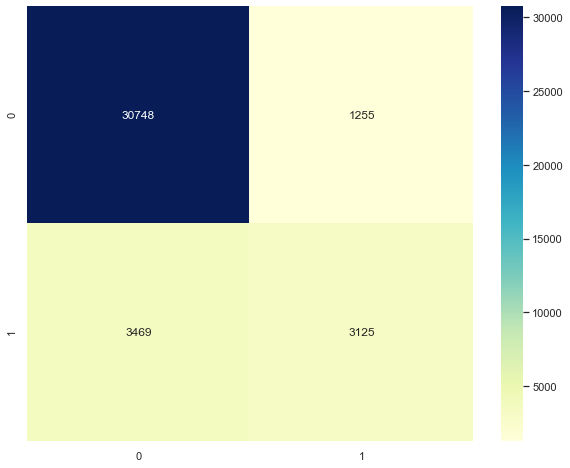

Classification Report:-
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     32003
           1       0.71      0.47      0.57      6594

    accuracy                           0.88     38597
   macro avg       0.81      0.72      0.75     38597
weighted avg       0.87      0.88      0.87     38597


--------------------------------------------------------------------------------

Confusion Matrix:-


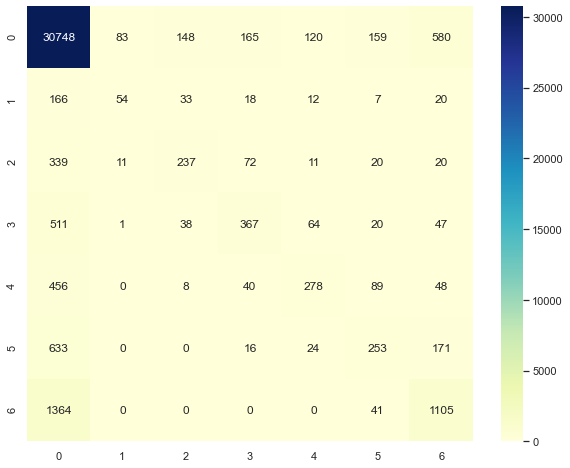

Classification Report:-
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     32003
          15       0.36      0.17      0.24       310
          21       0.51      0.33      0.40       710
          27       0.54      0.35      0.43      1048
          33       0.55      0.30      0.39       919
          42       0.43      0.23      0.30      1097
          48       0.55      0.44      0.49      2510

    accuracy                           0.86     38597
   macro avg       0.55      0.40      0.45     38597
weighted avg       0.83      0.86      0.84     38597



In [116]:
clf_binary = RandomForestClassifier(bootstrap=True,
                                    max_depth=20,
                                    max_features=0.9,
                                    max_leaf_nodes=None,
                                    min_samples_split=7,
                                    n_estimators=258,
                                    n_jobs=10,
                                    random_state=RANDOM_SEED)
clf_multi = RandomForestClassifier(bootstrap=True,
                                   max_depth=13,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_samples_split=5,
                                   n_estimators=470,
                                   n_jobs=10,
                                   random_state=RANDOM_SEED)

score_bi_model(clf_binary, clf_multi)

In [117]:
def make_submission_file(clf_binary, clf_multi, test_df=test_df, train_df=train_df, features_binary=selected_features_mi_binary,
                         features_multi=selected_features_mi_multi):
    clf_binary.fit(train_df[features_binary], train_df['Topup_Binary'])
    pred_binary = clf_binary.predict(test_df[features_binary])
    binary_class = pd.DataFrame({'ID': test_df['ID'],
                                 'Topup_Binary': pred_binary})
    test_df_new = test_df.set_index('ID').join(binary_class.set_index('ID'))
    
    clf_multi.fit(train_df[train_df['Topup_Binary'] == 1][features_multi],
                  train_df[train_df['Topup_Binary'] == 1]['Top-up Month Encoded'])
    pred_multi = clf_multi.predict(test_df_new[test_df_new['Topup_Binary'] == 1][features_multi])
    multi_class = pd.DataFrame({'ID': test_df_new[test_df_new['Topup_Binary'] == 1].index,
                                'Multi_Prediction': pred_multi})
    test_df_new = test_df_new.reset_index()
    test_df_final = test_df_new.set_index('ID').join(multi_class.set_index('ID'))
    test_df_final = test_df_final.reset_index()
    
    test_df_final['Prediction'] = test_df_final['Multi_Prediction']
    test_df_final['Prediction'] = test_df_final['Prediction'].fillna(test_df_final['Topup_Binary'])
    
    reverse_mask = {48 : ' > 48 Months',
                    0 : 'No Top-up Service',
                    15 : '12-18 Months',
                    42 : '36-48 Months',
                    21 : '18-24 Months',
                    27 : '24-30 Months',
                    33 : '30-36 Months'}
    test_df_final['Top-up Month'] = test_df_final['Prediction'].map(reverse_mask)
    output = test_df_final[['ID', 'Top-up Month']]
    output.to_csv('submission.csv', index=False)
    print('SUCCESS! File Saved. All the best!')

In [118]:
clf_binary = RandomForestClassifier(bootstrap=True,
                                    max_depth=20,
                                    max_features=0.9,
                                    max_leaf_nodes=None,
                                    min_samples_split=7,
                                    n_estimators=258,
                                    n_jobs=10,
                                    random_state=RANDOM_SEED)
clf_multi = RandomForestClassifier(bootstrap=True,
                                   max_depth=13,
                                   max_features='sqrt',
                                   max_leaf_nodes=None,
                                   min_samples_split=5,
                                   n_estimators=470,
                                   n_jobs=10,
                                   random_state=RANDOM_SEED)

make_submission_file(clf_binary, clf_multi)

SUCCESS! File Saved. All the best!


<h1 align="center" style='color: white; background-color: #be2830'>Deep Learning</h1>

In [119]:
print(f"Current Tensorflow version is: {tf.__version__}")

Current Tensorflow version is: 2.4.1


In [120]:
all_features = numerical_features + categorical_features

In [121]:
le = LabelEncoder()

transformed_labels = le.fit_transform(train_df['Top-up Month'])
train_df['Top-up Month'] = transformed_labels
print(le.classes_)

[' > 48 Months' '12-18 Months' '18-24 Months' '24-30 Months'
 '30-36 Months' '36-48 Months' 'No Top-up Service']


In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[all_features],
                                                      train_df['Top-up Month'],
                                                      test_size = 0.3,
                                                      random_state = RANDOM_SEED,
                                                      stratify=train_df['Top-up Month'],
                                                      shuffle=True)

Neural networks usually tend to overfit the data in case pf imbalanced class classifications, so let's generate some synthetic samples by oversampling.

In [123]:
# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)

# counter = Counter(y_train)
# for k,v in counter.items():
#     per = v / len(y_train) * 100
#     print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# # plot the distribution
# plt.bar(counter.keys(), counter.values())
# plt.show()

In [124]:
# pca = PCA().fit(X_train)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [125]:
# pca = PCA(n_components=5)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_valid = pca.transform(X_valid)

In [126]:
NUM_EPOCHS = 50
BATCH_SIZE = 32
lr = 0.001

In [127]:
class MultiClassClassifier:
    def __init__(self, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid, NUM_EPOCHS = NUM_EPOCHS,
                 BATCH_SIZE = BATCH_SIZE, lr = lr, full_train = False):
        '''
        Initializes the class with some pre-defined variables.
        Prints the model summary.
        '''
        self.X_train = X_train
        self.y_train = tf.one_hot(y_train, 7)
        self.X_valid = X_valid
        self.y_valid = tf.one_hot(y_valid, 7)
        self.NUM_EPOCHS = NUM_EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.lr = lr
        self.full_train = full_train
        self.model = self.get_model()
        return self.model.summary()
    
    def get_model(self):
        '''
        Creates a sequential model of below stated architecture and returns the model.
        '''
        model1 = Sequential()
        model1.add(BatchNormalization(input_dim = self.X_train.shape[1]))
        model1.add(Dense(256, activation='relu'))
        model1.add(Dropout(0.2))
        model1.add(BatchNormalization())
        model1.add(Dense(512, activation='relu'))
        model1.add(Dropout(0.2))
        model1.add(BatchNormalization())
        model1.add(Dense(512, activation='relu'))
        model1.add(Dropout(0.2))
        model1.add(BatchNormalization())
        model1.add(Dense(512, activation='relu'))
        model1.add(Dropout(0.2))
        model1.add(BatchNormalization())
        model1.add(Dense(128, activation='relu'))
        model1.add(Dropout(0.2))
        model1.add(BatchNormalization())
        model1.add(Dense(64, activation='relu'))
        model1.add(Dropout(0.2))
        model1.add(Dense(7, activation='softmax'))
        
        self.f1 = F1Score(num_classes=7, average='macro', name='f1_macro')
        self.fbeta = FBetaScore(num_classes=7, average='macro', name='f1_macro')
        
        model1.compile(loss = 'categorical_crossentropy',
                       optimizer = Adam(lr=self.lr),
                       metrics = [F1Score(num_classes=7, average='macro', name='f1_macro')])

        return model1
    
    def vis_model(self):
        plot_model(self.model, show_shapes=True, show_layer_names=True, to_file='model.png')
        img = Image.open('model.png')
        plot_dim = (20, 15)
        ax = plt.subplots(figsize=plot_dim)
        plt.imshow(img)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.show()
        os.remove('model.png')
        
        
    def fit(self):
        if self.full_train == False:
            early = EarlyStopping(monitor='val_f1_macro', min_delta=0.001, patience=10, verbose=0, mode='max', baseline=None,
                                  restore_best_weights=True)
            lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001,
                                   cooldown=0, min_lr=0.000001)
            checkpoint = ModelCheckpoint(monitor='val_f1_macro', filepath='Checkpoints\weights_DNN.hdf5', mode='max', verbose=0,
                                         save_best_only=True)
            NAME = f'Classifier_{self.BATCH_SIZE}_Batch_Size{int(time.time())}'
            tensorboard = TensorBoard(log_dir= 'logs\{}'.format(NAME))
            tqdm_callback = TQDMProgressBar()
            callbacks_list = [tensorboard, lr, checkpoint, early, tqdm_callback]

            self.history = self.model.fit(self.X_train, self.y_train,
                                          epochs=self.NUM_EPOCHS,
                                          batch_size=self.BATCH_SIZE,
                                          validation_data=(self.X_valid, self.y_valid),
                                          callbacks=callbacks_list,
                                          verbose=0)
        else:
            early = EarlyStopping(monitor='f1_macro', min_delta=0.001, patience=10, verbose=0, mode='max', baseline=None,
                                  restore_best_weights=True)
            lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001,
                                   cooldown=0, min_lr=0.000001)
            tqdm_callback = TQDMProgressBar()
            callbacks_list = [lr, early, tqdm_callback]

            self.history = self.model.fit(self.X_train, self.y_train,
                                          epochs=self.NUM_EPOCHS,
                                          batch_size=self.BATCH_SIZE,
                                          callbacks=callbacks_list,
                                          verbose=0)
    
    def predict(self, X):
        probas = self.model.predict(X)
        class_prediction = np.argmax(probas, axis=-1)
        return class_prediction
    
    def rate_model(self, predictions, y_true):
        plt.figure(figsize=(10,8))
        sns.heatmap(confusion_matrix(y_true, predictions), annot=True, fmt='g', cmap="YlGnBu")
        plt.show()
        result1 = classification_report(y_valid, predictions)
        print('Classification Report:-')
        print (result1)

In [128]:
clf = MultiClassClassifier()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 76)                304       
_________________________________________________________________
dense (Dense)                (None, 256)               19712     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2

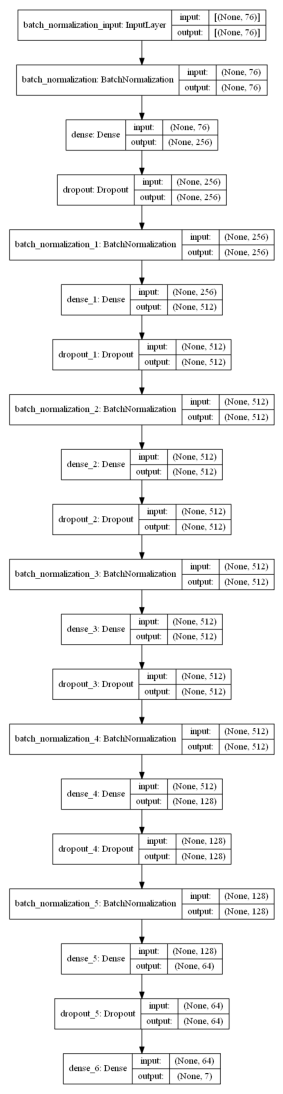

In [129]:
clf.vis_model()

In [130]:
clf.fit()

Epoch 1/50



Epoch 2/50



Epoch 3/50



Epoch 4/50



Epoch 5/50



Epoch 6/50



Epoch 7/50



Epoch 8/50



Epoch 9/50



Epoch 10/50



Epoch 11/50



Epoch 12/50



Epoch 13/50



Epoch 14/50



Epoch 15/50



Epoch 16/50



Epoch 17/50



Epoch 18/50


In [131]:
clf.model.load_weights('Checkpoints\weights_DNN.hdf5')

In [132]:
predictions = clf.predict(X = X_valid)

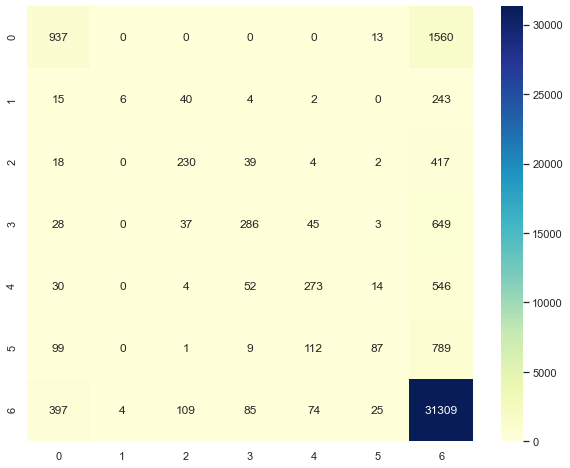

Classification Report:-
              precision    recall  f1-score   support

           0       0.61      0.37      0.46      2510
           1       0.60      0.02      0.04       310
           2       0.55      0.32      0.41       710
           3       0.60      0.27      0.38      1048
           4       0.54      0.30      0.38       919
           5       0.60      0.08      0.14      1097
           6       0.88      0.98      0.93     32003

    accuracy                           0.86     38597
   macro avg       0.63      0.33      0.39     38597
weighted avg       0.83      0.86      0.83     38597



In [133]:
clf.rate_model(predictions, y_valid)

In [134]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=clf.history.epoch, y=clf.history.history['val_loss'], name = 'Validation Loss',
                         line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=clf.history.epoch, y=clf.history.history['loss'], name='Training Loss',
                         line=dict(color='royalblue', width=4, dash='dash')))

fig.update_layout(title='Trained Loss History',
                   xaxis_title='Epoch',
                   yaxis_title='Value')

fig.show()

In [135]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=clf.history.epoch, y=clf.history.history['val_f1_macro'], name='Validation F1',
                         line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=clf.history.epoch, y=clf.history.history['f1_macro'], name='Training F1',
                         line=dict(color='firebrick', width=4, dash='dash')))

fig.update_layout(title='Trained F1 History',
                   xaxis_title='Epoch',
                   yaxis_title='Value')

fig.show()

In [136]:
test_df.head()

ID  Tenure  AssetCost  DisbursalAmount      EMI  DisbursalDate  \
0    4      46     480000         365000.0   1000.0         734500   
1    5      45     480000         285000.0   9300.0         734621   
2    6      48     580000         400000.0  35800.0         735163   
3   25      36     725000         500000.0  52000.0         735009   
4  119      48     617000         400000.0  35400.0         734837   

   MaturityDAte  AuthDate    LTV   AGE  MonthlyIncome  \
0        735876    734500  75.83  50.0       32069.00   
1        735964    734621  57.44  35.0       25000.00   
2        736582    735163  68.97  37.0       23333.33   
3        736004    735009  61.79  55.0       91666.67   
4        736303    734837  59.09  48.0       12500.00   

   DISBURSED-AMT/HIGH CREDIT_bureau  CURRENT-BAL_bureau  OVERDUE-AMT_bureau  \
0                         2964588.0           2191274.0                 0.0   
1                         1939813.0            907231.0                 0.0   
2                         3237361.0            102800.0                 0.0   
3                          800000.0            127593.0                 0.0   
4                          930000.0            116200.0                 0.0   

   WRITE-OFF-AMT_bureau  CUR BAL_Hist_Sum_bureau  AMT OVERDUE_Hist_Sum_bureau  \
0                   0.0               75444793.0                      77502.0   
1                   0.0               41077711.0                     185821.0   
2                   0.0               25087010.0                     598111.0   
3                   0.0               10872525.0                          0.0   
4                   0.0               18070247.0                      11116.0   

   AMT PAID_Hist_Sum_bureau  SELF-INDICATOR_False_bureau  \
0                       0.0                            3   
1                       0.0                            7   
2                       0.0                           10   
3                       0.0                            1   
4                19080000.0                            1   

   SELF-INDICATOR_True_bureau  MATCH-TYPE_PRIMARY_bureau  \
0                           1                          4   
1                           1                          8   
2                           2                         12   
3                           1                          2   
4                           1                          2   

   MATCH-TYPE_SECONDARY_bureau  ACCT-TYPE_Auto Loan (Personal)_bureau  \
0                            0                                      0   
1                            0                                      0   
2                            0                                      7   
3                            0                                      0   
4                            0                                      1   

   ACCT-TYPE_Business Loan Priority Sector  Agriculture_bureau  \
0                                                  0             
1                                                  0             
2                                                  0             
3                                                  1             
4                                                  0             

   ACCT-TYPE_Commercial Vehicle Loan_bureau  ACCT-TYPE_Gold Loan_bureau  \
0                                         0                           0   
1                                         0                           3   
2                                         0                           1   
3                                         0                           0   
4                                         0                           0   

   ACCT-TYPE_Kisan Credit Card_bureau  ACCT-TYPE_Other_bureau  \
0                                   0                       0   
1                                   0                       0   
2                                   0                       0   
3        

In [137]:
def prepare_predictions_nn(clf, test_df=test_df, le=le):
    clf.fit()
    predictions = clf.predict(X = test_df[all_features])
    output = pd.DataFrame({'ID': test_df['ID'],
                           'Top-up Month': predictions})
    output['Top-up Month'] = le.inverse_transform(output['Top-up Month'])
    output.to_csv('submission.csv', index=False)
    print('SUCCESS! File Saved. All the best!')

In [138]:
# clf = MultiClassClassifier(X_train = train_df[all_features], y_train = train_df['Top-up Month'], full_train = True)
clf = MultiClassClassifier()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 76)                304       
_________________________________________________________________
dense_7 (Dense)              (None, 256)               19712     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)              

In [139]:
prepare_predictions_nn(clf)

Epoch 1/50



Epoch 2/50



Epoch 3/50



Epoch 4/50



Epoch 5/50



Epoch 6/50



Epoch 7/50



Epoch 8/50



Epoch 9/50



Epoch 10/50



Epoch 11/50



Epoch 12/50



Epoch 13/50



Epoch 14/50



Epoch 15/50



Epoch 16/50



Epoch 17/50



Epoch 18/50



Epoch 19/50



Epoch 20/50



Epoch 21/50



Epoch 22/50



Epoch 23/50



Epoch 24/50



Epoch 25/50



Epoch 26/50



Epoch 27/50



Epoch 28/50



Epoch 29/50




SUCCESS! File Saved. All the best!
